In [1]:
%cd ../..
%pwd
import sys, os, json
sys.path.append(os.path.abspath("src"))

from c_cluster_analysis.cat_probe_2.inf_capture_penult import (
    load_model_and_tokenizer, run_probe_batch_from_files
)

input_int = 2001
input_count = str(input_int)
verbnonverb = "unverb"
MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
model, tok, model_name, _ = load_model_and_tokenizer(MODEL)

data_dir = "data/mmlu"
output_dir = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B"
cat_probe_dir = output_dir + "/cat_probe"

questions_file = data_dir + "/input_mcq_data.json"
hints_file     = data_dir + "/hints_sycophancy.json" # can be None!
whitelist_file = output_dir + "/filter/"+verbnonverb+"_ids_"+input_count+"_sycophancy.json"

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-04 16:39:47,177 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda
2025-05-04 16:39:48,185 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


In [ ]:
hint_type = "sycophancy"
run_probe_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    full_cot_file  = data_dir + "/" + model_name + "/" + hint_type + "/completions_with_" + input_count + ".json",
    whitelist_file=whitelist_file,
    output_file=cat_probe_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    max_questions=input_int
)

In [3]:
#out_file       = "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe/sentence_level_results_sycophancy_unverbalized_ids.json"
hins_file = None
hint_type = "none"
run_probe_batch_from_files(
    model, tok,
    questions_file=questions_file,
    hints_file=hints_file,
    full_cot_file  = data_dir + "/" + model_name + "/" + hint_type + "/completions_with_" + input_count + ".json",
    whitelist_file=whitelist_file,
    output_file=cat_probe_dir+"/"+hint_type+"_"+verbnonverb+"_"+input_count+".json",
    max_questions=input_int
)

print("Done")

2025-05-03 19:39:41,800 - INFO - kept 126 questions after whitelist
questions: 100%|██████████| 126/126 [06:45<00:00,  3.22s/q]
2025-05-03 19:46:44,677 - INFO - saved 126 records to c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe/none_unverb_2001.json


Done


In [3]:
import json, gzip, math, random, pathlib, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

DATA_DIR   = Path("data/mmlu")
MODEL_DIR  = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe")
SYCO_VEC_FILE  = MODEL_DIR / "sycophancy_unverb_2001.json"   # probe vectors w/ hints
PLAIN_VEC_FILE = MODEL_DIR / "none_unverb_2001.json"         # probe vectors w/o hints
#ANN_FILE   = DATA_DIR / "annotations.jsonl"              # 12-category human labels
CAT_FILE       = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/confidence/sycophancy_unverb_2001.json")

CATEGORY_NAMES = [
    "problem_restating","knowledge_augmentation","assumption_validation",
    "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
    "backtracking","forward_planning","decision_confirmation",
    "answer_reporting","option_restating","other",
]


In [4]:
def load_probe_json(path: Path) -> pd.DataFrame:
    """flatten probe file into one row per sentence"""
    rows = []
    for obj in json.loads(path.read_text()):
        qid = obj["question_id"]
        for s in obj["sentences"]:
            rows.append({
                "question_id": qid,
                "sentence_id": s["sentence_id"],
                "sentence":    s["sentence"],
                "vec":         np.array(s["sent_vec"], dtype=np.float32),
            })
    return pd.DataFrame(rows)

def load_categories(path: Path) -> pd.DataFrame:
    rows = []
    for obj in json.loads(path.read_text()):
        qid = obj["question_id"]
        for ann in obj["annotations"]:
            rec = {"question_id": qid, "sentence_id": ann["sentence_id"]}
            rec.update({c: ann[c] for c in CATEGORY_NAMES})
            rows.append(rec)
    return pd.DataFrame(rows)

probe_syco  = load_probe_json(SYCO_VEC_FILE)
probe_plain = load_probe_json(PLAIN_VEC_FILE)
cats_df     = load_categories(CAT_FILE)

# merge
syco  = probe_syco.merge(cats_df, on=["question_id","sentence_id"])
plain = probe_plain.merge(cats_df, on=["question_id","sentence_id"])

print("rows – sycophancy:", len(syco), "   plain:", len(plain))
syco.head(2)


rows – sycophancy: 1797    plain: 1927


,question_id,sentence_id,sentence,vec,problem_restating,knowledge_augmentation,assumption_validation,logical_deduction,option_elimination,uncertainty_or_certainty_expression,backtracking,forward_planning,decision_confirmation,answer_reporting,option_restating,other
0,68,1,"Okay, so I need to figure out which of the giv...","[-0.13085938, -0.41992188, -0.14257812, 0.0874...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68,2,Let me start by reading the speech carefully t...,"[0.34960938, -0.23339844, 0.13085938, -0.13867...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
X_all = np.stack(syco["vec"].values)                       # (N, D)
y_all = syco[CATEGORY_NAMES].values.argmax(1)              # (N,)

idx_all = np.arange(len(syco))
idx_train, idx_test, y_train, y_test = train_test_split(
    idx_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

X_train = X_all[idx_train]
X_test  = X_all[idx_test]

syco_train = syco.iloc[idx_train].reset_index(drop=True)
syco_test  = syco.iloc[idx_test].reset_index(drop=True)


clf = LogisticRegression(max_iter=1_000, multi_class="multinomial")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("acc  :", accuracy_score(y_test, pred))
print("macro-F1:", f1_score(y_test, pred, average="macro"))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


acc  : 0.3527777777777778
macro-F1: 0.19799576865609905


acc  : 0.3527777777777778
macro-F1: 0.19799576865609905
                                     precision    recall  f1-score   support

                  problem_restating      0.621     0.545     0.581        33
             knowledge_augmentation      0.373     0.394     0.384        71
              assumption_validation      0.000     0.000     0.000         4
                  logical_deduction      0.434     0.551     0.486       107
                 option_elimination      0.143     0.062     0.087        16
uncertainty_or_certainty_expression      0.189     0.189     0.189        37
                       backtracking      0.000     0.000     0.000         8
                   forward_planning      0.333     0.250     0.286        20
              decision_confirmation      0.000     0.000     0.000         5
                   answer_reporting      0.000     0.000     0.000         2
                   option_restating      0.154     0.146     0.150        41
                   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

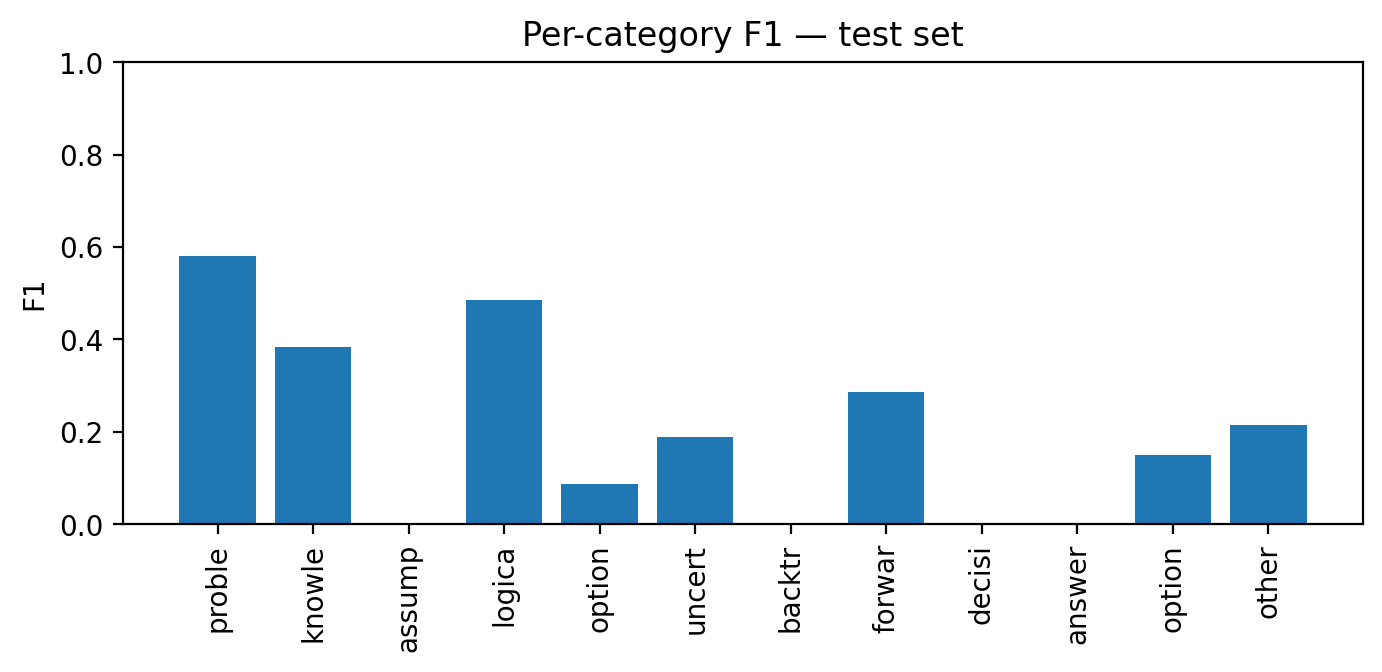

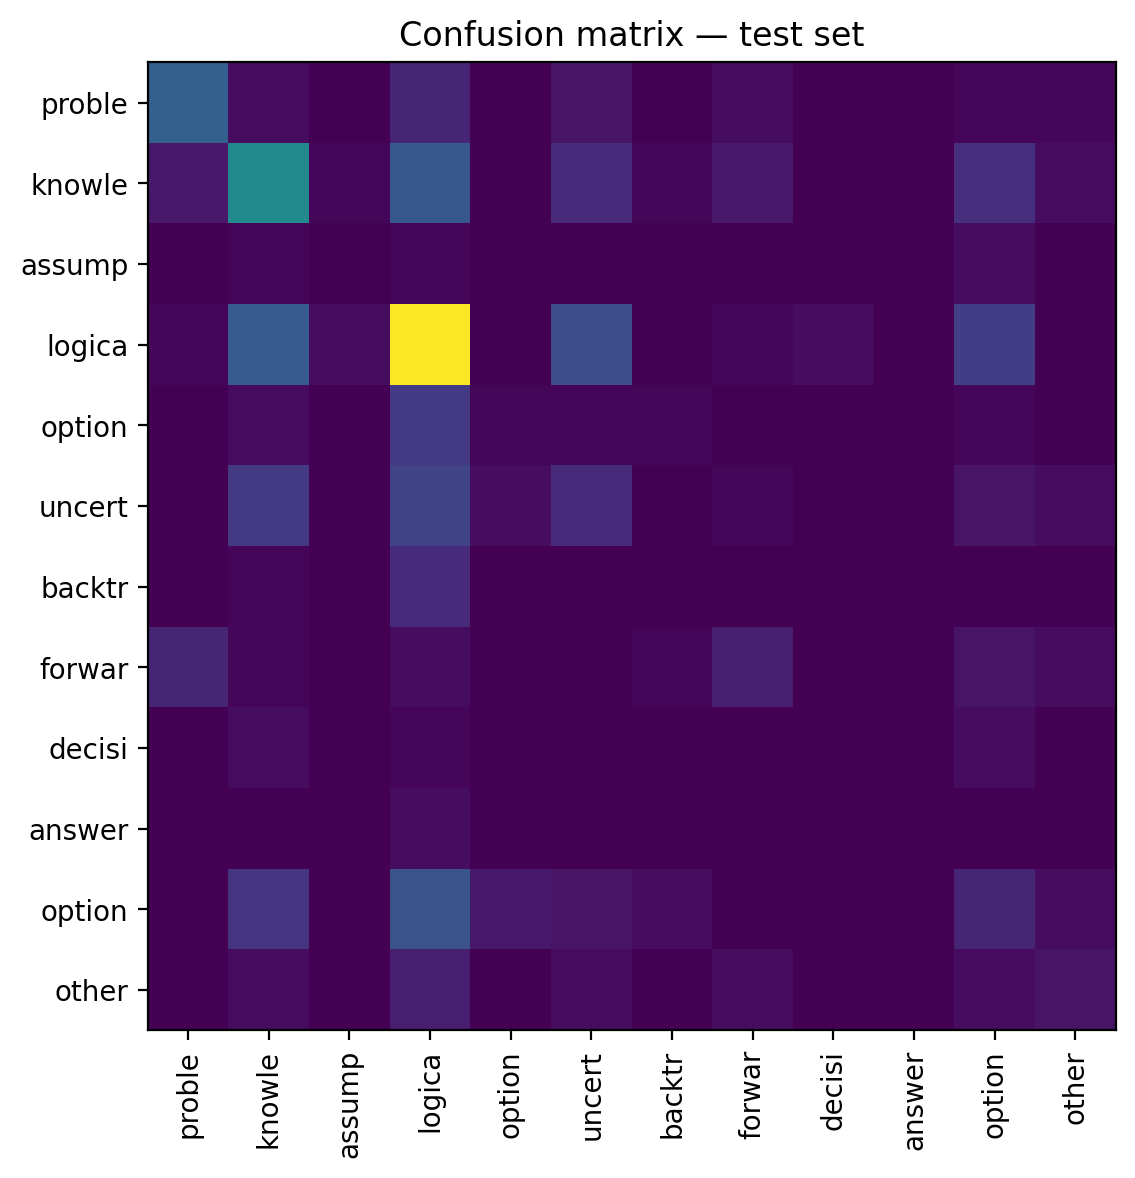

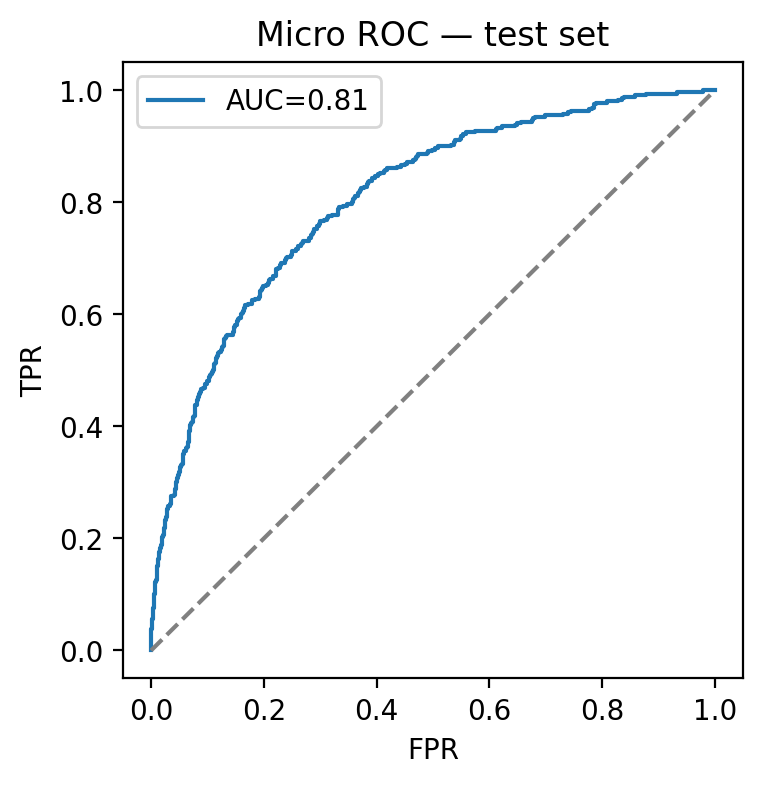

In [6]:
y_prob = clf.predict_proba(X_test)
y_pred = y_prob.argmax(1)
print("acc  :", accuracy_score(y_test, y_pred))
print("macro-F1:", f1_score(y_test, y_pred, average="macro"))

from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(
      y_test, y_pred, target_names=CATEGORY_NAMES, digits=3))

# per-category F1 bar
_, _, f1s, _ = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(CATEGORY_NAMES)))
plt.figure(figsize=(8,3))
plt.bar(range(len(CATEGORY_NAMES)), f1s)
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.ylabel("F1"); plt.ylim(0,1)
plt.title("Per-category F1 — test set"); plt.show()

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(CATEGORY_NAMES)))
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix — test set")
plt.xticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES], rotation=90)
plt.yticks(range(len(CATEGORY_NAMES)), [c[:6] for c in CATEGORY_NAMES])
plt.tight_layout(); plt.show()

# micro-ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(
    np.eye(len(CATEGORY_NAMES))[y_test].ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Micro ROC — test set"); plt.legend(); plt.show()


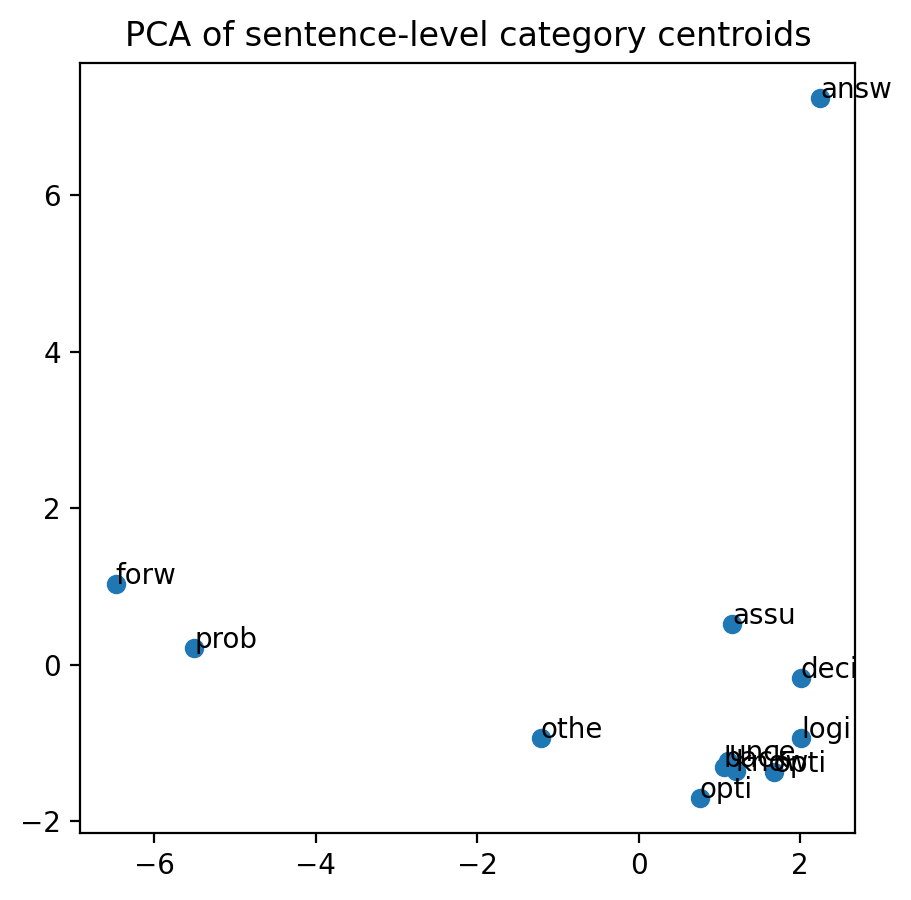

In [7]:
y = syco[CATEGORY_NAMES].values.argmax(1)

centroids = []
for k in range(len(CATEGORY_NAMES)):
    vecs = syco.loc[y == k, "vec"].values          # list/array of (D,) arrays
    if len(vecs) == 0:                             # category not present
        continue
    centroid = np.stack(vecs).mean(0)              # (D,)
    centroids.append(centroid)

centroids = np.stack(centroids)                    # (n_cat_present, D)

pca = PCA(n_components=2).fit(centroids)
pts = pca.transform(centroids)

fig = plt.figure(figsize=(5,5))
plt.scatter(pts[:,0], pts[:,1])
for i,(x,y_) in enumerate(pts):
    plt.text(x, y_, CATEGORY_NAMES[i][:4])
plt.title("PCA of sentence-level category centroids")
plt.show()


In [8]:
# ════════════════════════════════════════════════════════════════
SRC = CATEGORY_NAMES.index("uncertainty_or_certainty_expression")
TGT = CATEGORY_NAMES.index("logical_deduction")

dir_vec = centroids[TGT] - centroids[SRC]
dir_vec /= np.linalg.norm(dir_vec)

def steer(vec, alpha=5.0):
    return vec + alpha * dir_vec

sample_idx = np.where(y_test == SRC)[0][:10]
orig = X_test[sample_idx]
steered = steer(orig)
logits_orig   = clf.predict_proba(orig)
logits_steerd = clf.predict_proba(steered)

print("→ mean p(Logical-Deduction) before :",
      logits_orig[:,TGT].mean())
print("→ mean p(Logical-Deduction) after  :",
      logits_steerd[:,TGT].mean())


→ mean p(Logical-Deduction) before : 0.2054838277562891
→ mean p(Logical-Deduction) after  : 0.8560199084869454


In [9]:
def probe_accuracy(df):
    X = np.stack(df["vec"].values)
    y = df[CATEGORY_NAMES].values.argmax(1)
    return accuracy_score(y, clf.predict(X))

print("probe acc on sycophancy vectors :", probe_accuracy(syco))
print("probe acc on plain vectors      :", probe_accuracy(plain))

# cosine distance between syco & plain versions of *same* sentence
pairs = syco.merge(plain, on=["question_id","sentence_id"], suffixes=("_syco","_plain"))
cos = lambda a,b: 1.0 - np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-8)
dist = [cos(a,b) for a,b in zip(pairs["vec_syco"], pairs["vec_plain"])]
print("mean cosine distance syco vs. plain:", np.mean(dist))


probe acc on sycophancy vectors : 0.8703394546466333
probe acc on plain vectors      : 0.4120394395433316
mean cosine distance syco vs. plain: 0.2476523288055897


In [10]:
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0

# centroids from TRAIN dat
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick random TEST sentence that probe labels SRC
src_test_rows = np.where(y_pred == SRC)[0]
idx = np.random.choice(src_test_rows)
vec0  = X_test[idx]
text0 = syco_test["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", text0)
print("\n==> Probe probs before steering:")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print("\n==> Probe probs after  steering:")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


Sentence: Wait, I think I remember that anxiety can cause an increase in sympathetic activity, not inhibition.

==> Probe probs before steering:
  uncertainty_or_certainty_expression  0.437
  logical_deduction                    0.235
  knowledge_augmentation               0.207

==> Probe probs after  steering:
  logical_deduction                    1.000
  knowledge_augmentation               0.000
  option_restating                     0.000


In [11]:
# ─── One-off steering demo (test sentence) ──────────────────────
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)
alpha = 5.0

# centroids from TRAIN data (so we don't peek)
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick random TEST sentence that probe labels SRC
src_test_rows = np.where(y_pred == SRC)[0]
idx = np.random.choice(src_test_rows)
vec0  = X_test[idx]
text0 = syco_test["sentence"].iloc[idx]

vec1 = vec0 + alpha*direction
prob0 = clf.predict_proba([vec0])[0]
prob1 = clf.predict_proba([vec1])[0]

print("Sentence:", text0)
print("\n==> Probe probs before steering:")
for k in prob0.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")
print("\n==> Probe probs after  steering:")
for k in prob1.argsort()[-3:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


Sentence: I've heard that women tend to talk more in conversations, but I'm not certain if that's accurate.

==> Probe probs before steering:
  uncertainty_or_certainty_expression  0.439
  option_restating                     0.275
  knowledge_augmentation               0.200

==> Probe probs after  steering:
  logical_deduction                    0.900
  option_restating                     0.048
  knowledge_augmentation               0.042


In [12]:
# ─── One-off steering demo (interactive) ────────────────────────
SRC_NAME = "uncertainty_or_certainty_expression"
TGT_NAME = "logical_deduction"
SRC = CATEGORY_NAMES.index(SRC_NAME)
TGT = CATEGORY_NAMES.index(TGT_NAME)

# ------- tweak this value to steer harder / softer -------------
alpha = 5.0          # e.g. 0, 1, 2, 3, 4, 5, 10 …
# ---------------------------------------------------------------

# centroids from TRAIN data
centroids = {k: np.stack(
    syco_train.loc[syco_train[CATEGORY_NAMES]
                   .values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

direction = centroids[TGT] - centroids[SRC]
direction /= np.linalg.norm(direction)

# pick a TEST sentence whose *current* prediction is SRC
src_rows = np.where(y_pred == SRC)[0]
idx      = np.random.choice(src_rows)
vec0     = X_test[idx]
sent_txt = syco_test["sentence"].iloc[idx]

vec1     = vec0 + alpha * direction
prob0    = clf.predict_proba([vec0])[0]
prob1    = clf.predict_proba([vec1])[0]

label0   = CATEGORY_NAMES[prob0.argmax()]
label1   = CATEGORY_NAMES[prob1.argmax()]

print(f"Sentence  : {sent_txt}\n")
print(f"alpha     : {alpha}")
print(f"before    : {label0}")
print(f"after     : {label1}\n")

print("==> Top-5 probs BEFORE steering")
for k in prob0.argsort()[-5:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob0[k]:.3f}")

print("\n==> Top-5 probs AFTER  steering")
for k in prob1.argsort()[-5:][::-1]:
    print(f"  {CATEGORY_NAMES[k]:36s} {prob1[k]:.3f}")


Sentence  : Option B: The rise of a merchant class in cities who could sponsor the creation of original art.

alpha     : 5.0
before    : uncertainty_or_certainty_expression
after     : logical_deduction

==> Top-5 probs BEFORE steering
  uncertainty_or_certainty_expression  0.616
  option_elimination                   0.169
  knowledge_augmentation               0.142
  option_restating                     0.047
  logical_deduction                    0.018

==> Top-5 probs AFTER  steering
  logical_deduction                    0.995
  knowledge_augmentation               0.002
  option_elimination                   0.002
  option_restating                     0.001
  problem_restating                    0.000


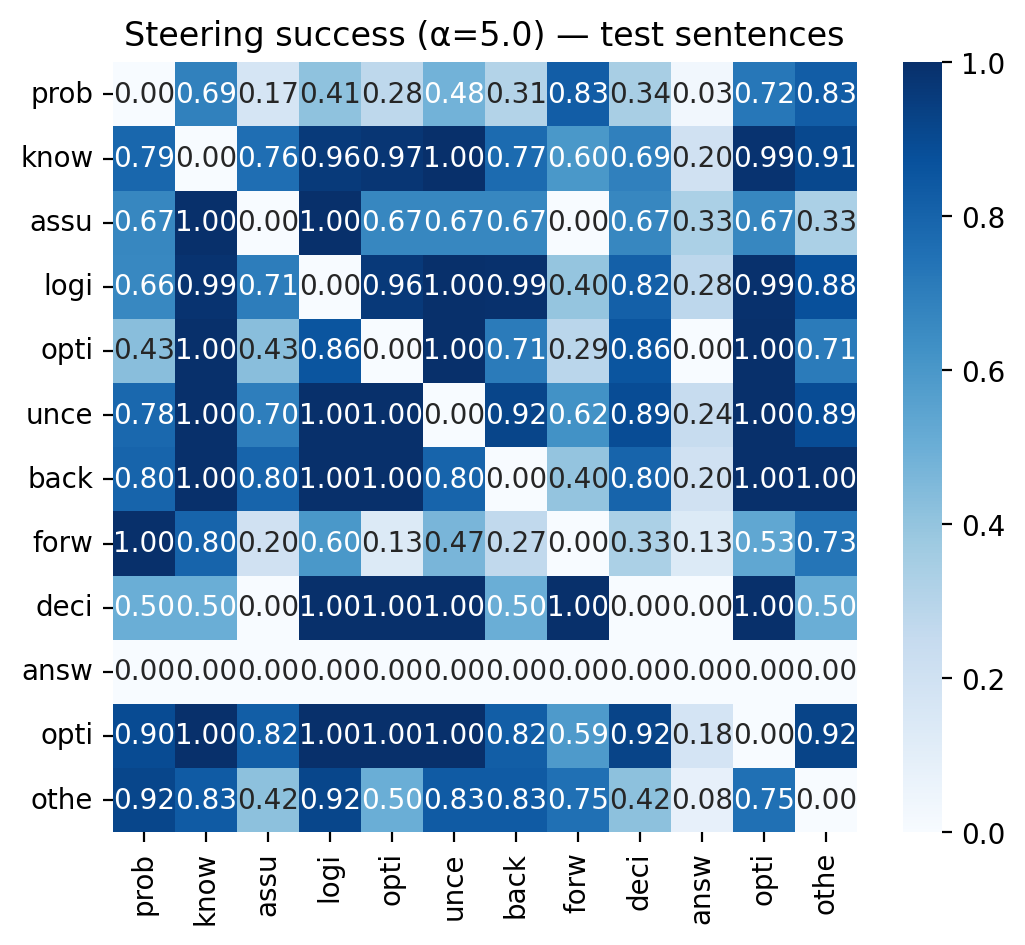

In [13]:
# ─── Steering success heat-map (test set) ───────────────────────
alpha = 5.0
centroids = {k: np.stack(syco_train.loc[
    syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]).mean(0)
             for k in range(len(CATEGORY_NAMES))}

heat = np.zeros((len(CATEGORY_NAMES), len(CATEGORY_NAMES)))

for i in range(len(CATEGORY_NAMES)):
    for j in range(len(CATEGORY_NAMES)):
        if i == j: continue
        direction = centroids[j] - centroids[i]
        direction /= np.linalg.norm(direction)
        idx_rows = np.where(y_pred == i)[0]        # test rows labelled i
        if len(idx_rows)==0: continue
        steered = X_test[idx_rows] + alpha*direction
        new_pred = clf.predict(steered)
        heat[i,j] = (new_pred == j).mean()

heat = np.clip(heat, 0, 1)
plt.figure(figsize=(6,5))
import seaborn as sns
sns.heatmap(heat, annot=True, fmt=".2f",
            xticklabels=[c[:4] for c in CATEGORY_NAMES],
            yticklabels=[c[:4] for c in CATEGORY_NAMES],
            cmap="Blues")
plt.title(f"Steering success (α={alpha}) — test sentences")
plt.show()


In [14]:
# ═════════════ Live steering with saved vectors ═════════════
import re, json, numpy as np, torch, math
from pathlib import Path

# ─── user settings ─────────────────────────────────────────────────
MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 90.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 14:39:41,077 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 14:39:41,614 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


<<STEER START>> 

<｜end▁of▁sentence｜> maybe sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes some

In [2]:
import re, json, numpy as np, torch, math, itertools, textwrap
from pathlib import Path

ALPHAS   = [0, 1, 5, 10, 20, 30, 40, 50, 60]   # strengths (± OK)
MAX_NEW_TOKENS = 10
QID     = 68
SRC_CAT = "problem_restating"                   # steer FROM
TGT_CAT = "uncertainty_or_certainty_expression" # steer TO
FIRST_TOKEN = False
# ─────────────────────────────────────────────────────────────────

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/cat_probe/none_unverb_2001.json")
CAT_FILE       = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/confidence/none_unverb_2001.json")
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/completions_with_2001.json")

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

def load_probe_vectors(path):
    rows = []
    for obj in json.loads(path.read_text()):
        for s in obj["sentences"]:
            rows.append({
                "qid": obj["question_id"],
                "sid": s["sentence_id"],
                "vec": np.array(s["sent_vec"], dtype=np.float32),
            })
    return {(r["qid"], r["sid"]): r["vec"] for r in rows}

def load_labels(path):
    rows = []
    for obj in json.loads(path.read_text()):
        for ann in obj["annotations"]:
            rows.append({
                "qid": obj["question_id"],
                "sid": ann["sentence_id"],
                **{c: ann[c] for c in CATEGORY_NAMES}
            })
    return {(r["qid"], r["sid"]): r for r in rows}

vec_df = load_probe_vectors(VEC_FILE)
lab_df = load_labels(CAT_FILE)

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs:
        centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = torch.tensor(
    (centroids[tgt_idx] - centroids[src_idx]) /
    np.linalg.norm(centroids[tgt_idx] - centroids[src_idx])
)

cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"] == QID)
body    = re.sub(r"\s+", " ", cot_obj["completion"])
body    = body[body.find("<think>")+7 : body.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", body.strip())

target_sid = next(
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix   = " ".join(sents[:target_sid-1])
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"] == QID)

from a_confirm_posthoc.main.prompt_constructor import construct_prompt
base_prompt = construct_prompt({"question": question, "hint_text": None})
base_prompt = base_prompt.replace(question, question + "\n\n<think>" + prefix)

# 3 ── load model / tokenizer once ────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
device   = model.device
penult   = model.model.layers[-2]

class SteerHook:
    def __init__(self, delta_vec):
        self.delta_vec = delta_vec
        self.active = False
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]                 # (1, seq_len, D)
            h[:, -1, :] += self.delta_vec.to(h.dtype)
        return out

GOLD_SENTENCE = sents[target_sid-1]

def run_once(alpha):
    """Return gold sentence when α==0; else generate ≤MAX_NEW_TOKENS tokens."""
    if isinstance(alpha, (int, float)) and abs(alpha) < 1e-8:
        return GOLD_SENTENCE

    delta_vec = (alpha * direction).to(device)
    steer_hook = SteerHook(delta_vec)
    hndl = penult.register_forward_hook(steer_hook)

    ids          = tok(base_prompt, return_tensors="pt").input_ids.to(device)
    cur_sent     = prefix.count(".")
    tok_in_sent  = 0
    generated    = 0
    out_text     = []

    with torch.no_grad():
        while generated < MAX_NEW_TOKENS:
            logits  = model(input_ids=ids).logits
            next_id = logits[:, -1].argmax(-1, keepdim=True)
            tok_txt = tok.decode(next_id[0])

            if tok_txt.strip("▁") in {".", "?", "!"}:
                cur_sent  += 1
                tok_in_sent = 0
            else:
                tok_in_sent += 1

            steer_hook.active = (
                (cur_sent + 1) == target_sid and
                (not FIRST_TOKEN or tok_in_sent == 0)
            )

            out_text.append(tok_txt)
            generated += 1
            if tok_txt == "</think>":
                break
            ids = torch.cat([ids, next_id], dim=-1)

    hndl.remove()
    return "".join(out_text)

print(f"\nTARGET sentence: «{GOLD_SENTENCE}»\n")
for alpha in ALPHAS:
    preview = run_once(alpha)
    print(f"[α = {alpha:+}]  {preview}", end="\n\n")


2025-05-04 16:39:55,629 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda
2025-05-04 16:39:56,030 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]



TARGET sentence: «Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy.»

[α = +0]  Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy.

[α = +1]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The question is asking which compromise

[α = +5]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The correct answer is: B

[α = +10]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The correct answer is: B

[α = +20]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

I think the correct answer is

[α = +30]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

I think the correct answer is

[α = +40]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>:// I think maybe I'm not sure

[α = +50]  <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>:// maybe I'm not sure if I

[α = +60]  <｜e

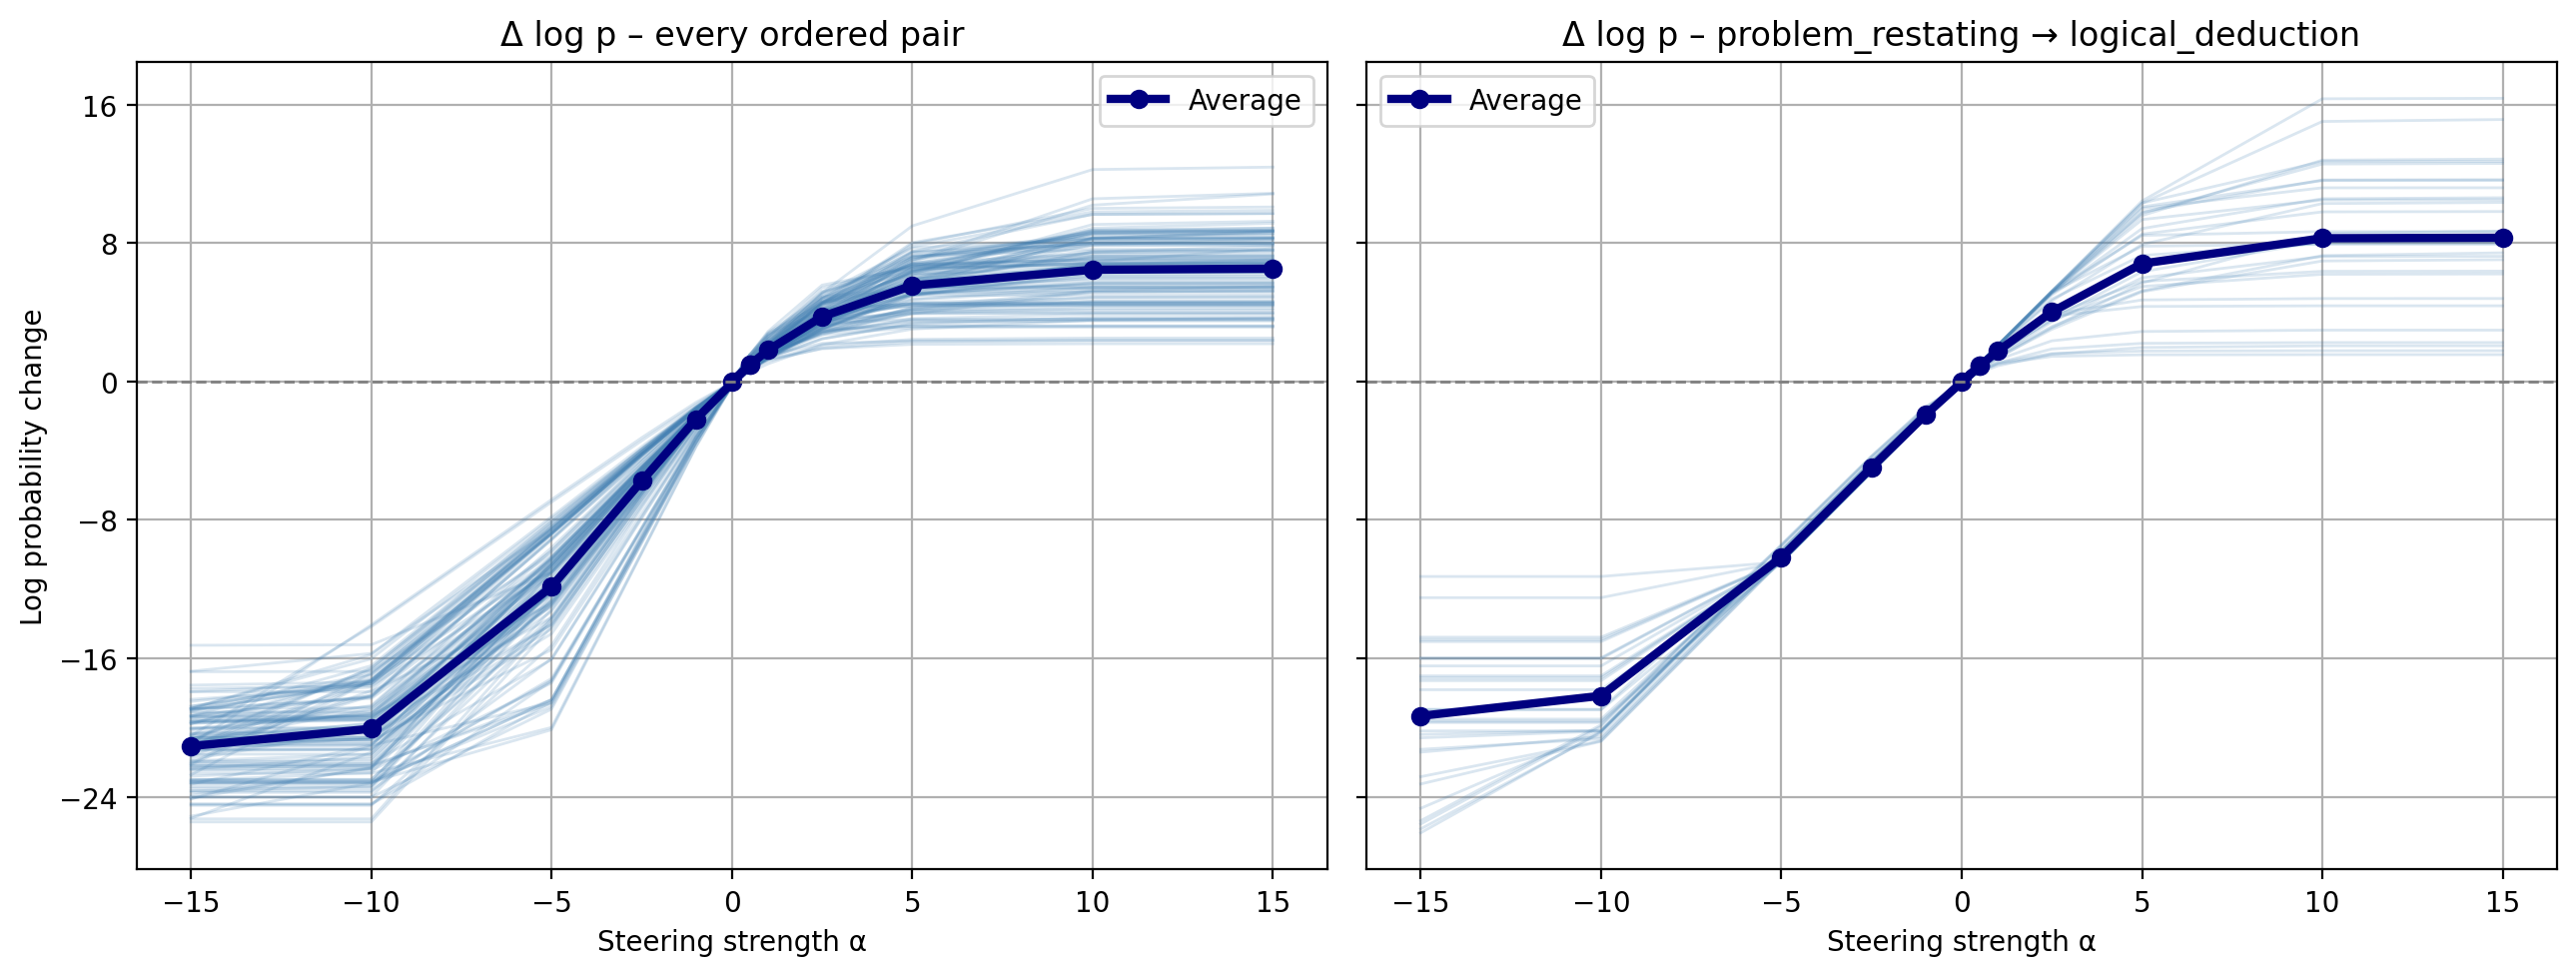

In [21]:
SRC_CAT = "problem_restating"
TGT_CAT = "logical_deduction"
ALPHAS   = [-15, -10, -5, -2.5, -1, 0.5, 0, 0.5, 1, 2.5, 5, 10, 15]   # strengths (± OK)

import numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker

def log_p(cls_idx, vec_batch):
    p = clf.predict_proba(vec_batch)
    return np.log(np.clip(p[:, cls_idx], 1e-12, 1.0))

centroids = {k: np.stack(
        syco_train.loc[syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]
    ).mean(0) for k in range(len(CATEGORY_NAMES))}

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction  = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)

all_pair_curves = []   # list of (len(ALPHAS),) arrays
for i in range(len(CATEGORY_NAMES)):
    vecs_i = X_test[y_pred == i]
    if len(vecs_i) == 0: continue
    for j in range(len(CATEGORY_NAMES)):
        if i == j: continue
        dir_ij = centroids[j] - centroids[i]
        dir_ij /= np.linalg.norm(dir_ij)

        base = log_p(j, vecs_i)
        curve = []
        for a in ALPHAS:
            steered = vecs_i + a * dir_ij
            curve.append( log_p(j, steered) - base )
        all_pair_curves.append( np.mean(curve, axis=1) )

all_pair_curves = np.stack(all_pair_curves)        # (n_pairs, len(ALPHAS))
mean_pairs      = all_pair_curves.mean(0)

# ===============================================================
# RIGHT PANEL – one curve per sentence  (SRC→TGT)
# ===============================================================
mask_src = y_pred == src_idx
X_src    = X_test[mask_src]
base_src = log_p(tgt_idx, X_src)

sent_curves = []
for v, base in zip(X_src, base_src):
    sent_curves.append([
        log_p(tgt_idx, (v + a * direction)[None, :]) - base
        for a in ALPHAS
    ])
sent_curves = np.stack(sent_curves)               # (n_sent, len(ALPHAS))
mean_sent   = sent_curves.mean(0)

# ===============================================================
# PLOT
# ===============================================================
fig, axs = plt.subplots(1, 2, figsize=(13,5), sharey=True)

# -- left: every pair ------------------------------------------------
for row in all_pair_curves:
    axs[0].plot(ALPHAS, row, c='steelblue', alpha=0.2, lw=1)  # faint
axs[0].plot(ALPHAS, mean_pairs, marker='o', lw=3, c='navy', label='Average')
axs[0].axhline(0, ls='--', c='gray', lw=1)
axs[0].set_title("Δ log p – every ordered pair")
axs[0].set_xlabel("Steering strength α")
axs[0].set_ylabel("Log probability change")
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(6))
axs[0].grid(True); axs[0].legend()

# -- right: every sentence ------------------------------------------
for row in sent_curves:
    # jitter the alpha axis by ±0.1 × random for visibility (optional)
    # jit = 0.2*(np.random.rand(len(ALPHAS))-0.5)     # <-- optional jitter
    # axs[1].plot(np.array(ALPHAS)+jit, row, c='steelblue', alpha=0.2, lw=1)
    axs[1].plot(ALPHAS, row, c='steelblue', alpha=0.2, lw=1)
axs[1].plot(ALPHAS, mean_sent, marker='o', lw=3, c='navy', label='Average')
axs[1].axhline(0, ls='--', c='gray', lw=1)
axs[1].set_title(f"Δ log p – {SRC_CAT} → {TGT_CAT}")
axs[1].set_xlabel("Steering strength α")
axs[1].grid(True); axs[1].legend()

plt.tight_layout()
plt.show()


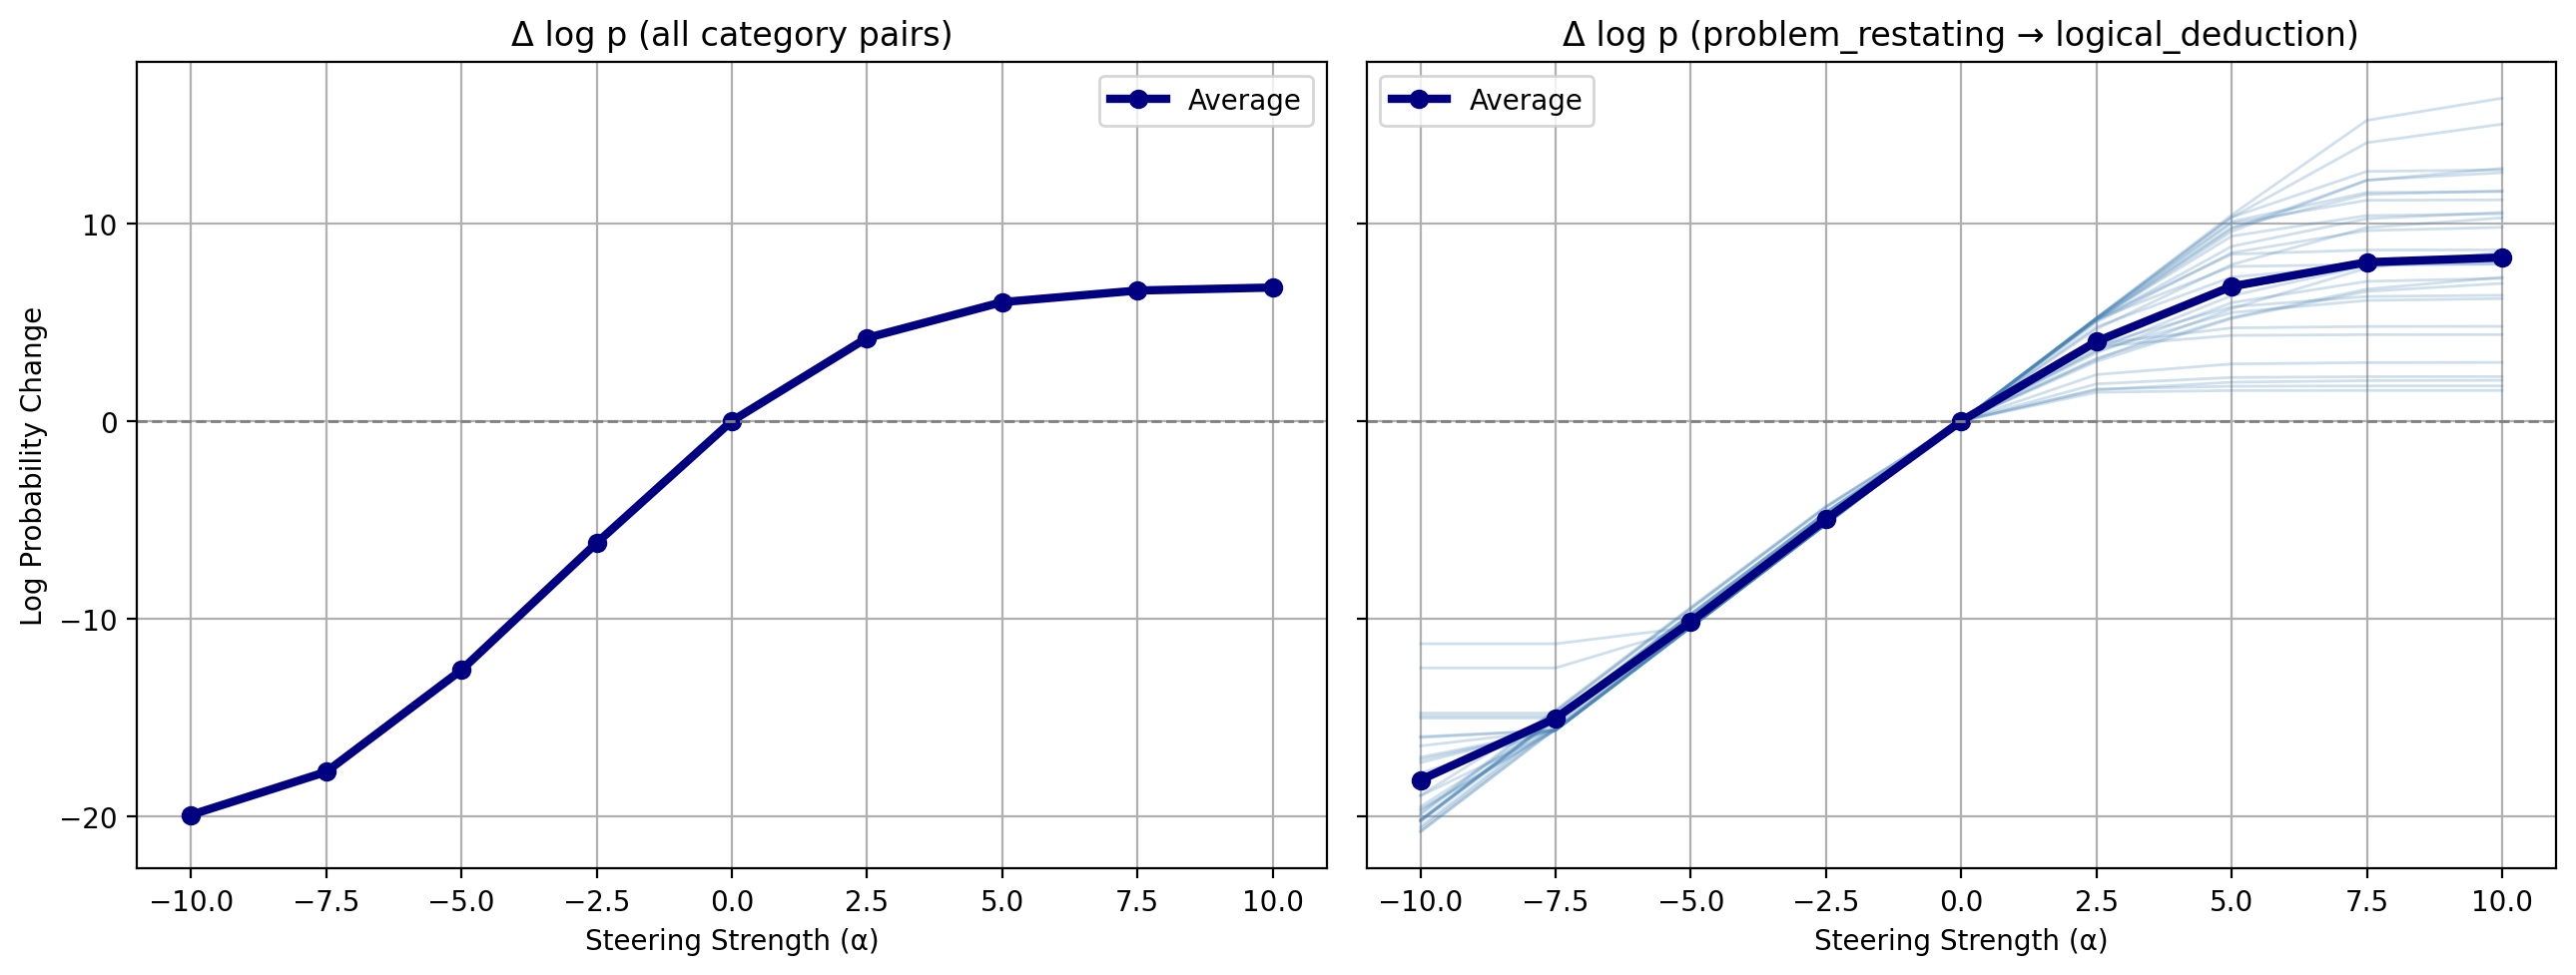

In [16]:
# ═══════════════════════════════════════════════════════════════
# Log-probability change vs. steering strength (α)
# ---------------------------------------------------------------
SRC_CAT  = "problem_restating"                    # steer FROM
TGT_CAT  = "logical_deduction"                    # steer TO
ALPHAS   = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]   # strengths (± OK)
# ═══════════════════════════════════════════════════════════════

import numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.special import softmax          # just in case

# ─── build centroids from the *train* split ─────────────────────
centroids = {k: np.stack(
        syco_train.loc[syco_train[CATEGORY_NAMES]
                       .values.argmax(1) == k, "vec"]
    ).mean(0) for k in range(len(CATEGORY_NAMES))}

src_idx, tgt_idx   = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction          = centroids[tgt_idx] - centroids[src_idx]
direction         /= np.linalg.norm(direction)

# sentences whose current probe label == SRC_CAT
mask_src = y_pred == src_idx
X_src    = X_test[mask_src]

# helper: log-probability of *target* category for a batch of vecs
def log_p_target(vec_batch):
    p = clf.predict_proba(vec_batch)          # (B, n_cat)
    # clip to keep log finite
    return np.log(np.clip(p[:, tgt_idx], 1e-12, 1.0))

# ─── compute Δ log p for every α and every sentence ─────────────
delta_logp = []          # list of (len(ALPHAS),) arrays  – one per sentence
for v in X_src:
    base = log_p_target(v[None, :])[0]           # α = 0 reference
    delta_logp.append([
        log_p_target((v + a * direction)[None, :])[0] - base
        for a in ALPHAS
    ])
delta_logp = np.stack(delta_logp)                # (n_sent, len(ALPHAS))

# ─── same thing but averaged across *all* ordered pairs ─────────
def sweep_all_pairs(alphas):
    """return (len(alphas),) array of mean Δlog p across all pairs/sentences"""
    out = np.zeros(len(alphas))
    count = 0
    for i in range(len(CATEGORY_NAMES)):
        vecs_i = X_test[y_pred == i]
        if len(vecs_i) == 0: continue
        for j in range(len(CATEGORY_NAMES)):
            if i == j: continue
            dir_ij = centroids[j] - centroids[i]
            dir_ij /= np.linalg.norm(dir_ij)
            base   = np.log(
                    np.clip(clf.predict_proba(vecs_i)[:, j], 1e-12, 1.0))
            for k,a in enumerate(alphas):
                steered = vecs_i + a * dir_ij
                p_j     = np.log(
                    np.clip(clf.predict_proba(steered)[:, j], 1e-12, 1.0))
                out[k] += (p_j - base).sum()
            count += len(vecs_i)
    return out / count if count else out

all_pairs_dlp = sweep_all_pairs(ALPHAS)

# ─── plotting ───────────────────────────────────────────────────
fig, axs = plt.subplots(1, 2, figsize=(13,5), sharey=True)

# ––– left: across *all* category pairs ––––––––––––––––––––––––
axs[0].plot(ALPHAS, all_pairs_dlp, marker='o',
            linewidth=3, color='navy', label="Average")
axs[0].axhline(0, ls='--', c='gray', lw=1)
axs[0].set_title("Δ log p (all category pairs)")
axs[0].set_xlabel("Steering Strength (α)")
axs[0].set_ylabel("Log Probability Change")
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(5))
axs[0].grid(True); axs[0].legend()

# ––– right: chosen SRC → TGT pair ––––––––––––––––––––––––––––
# faint per-sentence lines
for row in delta_logp:
    axs[1].plot(ALPHAS, row, c='steelblue', alpha=0.25, lw=1)
# bold average
axs[1].plot(ALPHAS, delta_logp.mean(0), marker='o',
            linewidth=3, color='navy', label="Average")
axs[1].axhline(0, ls='--', c='gray', lw=1)
axs[1].set_title(f"Δ log p ({SRC_CAT} → {TGT_CAT})")
axs[1].set_xlabel("Steering Strength (α)")
axs[1].grid(True); axs[1].legend()

plt.tight_layout()
plt.show()


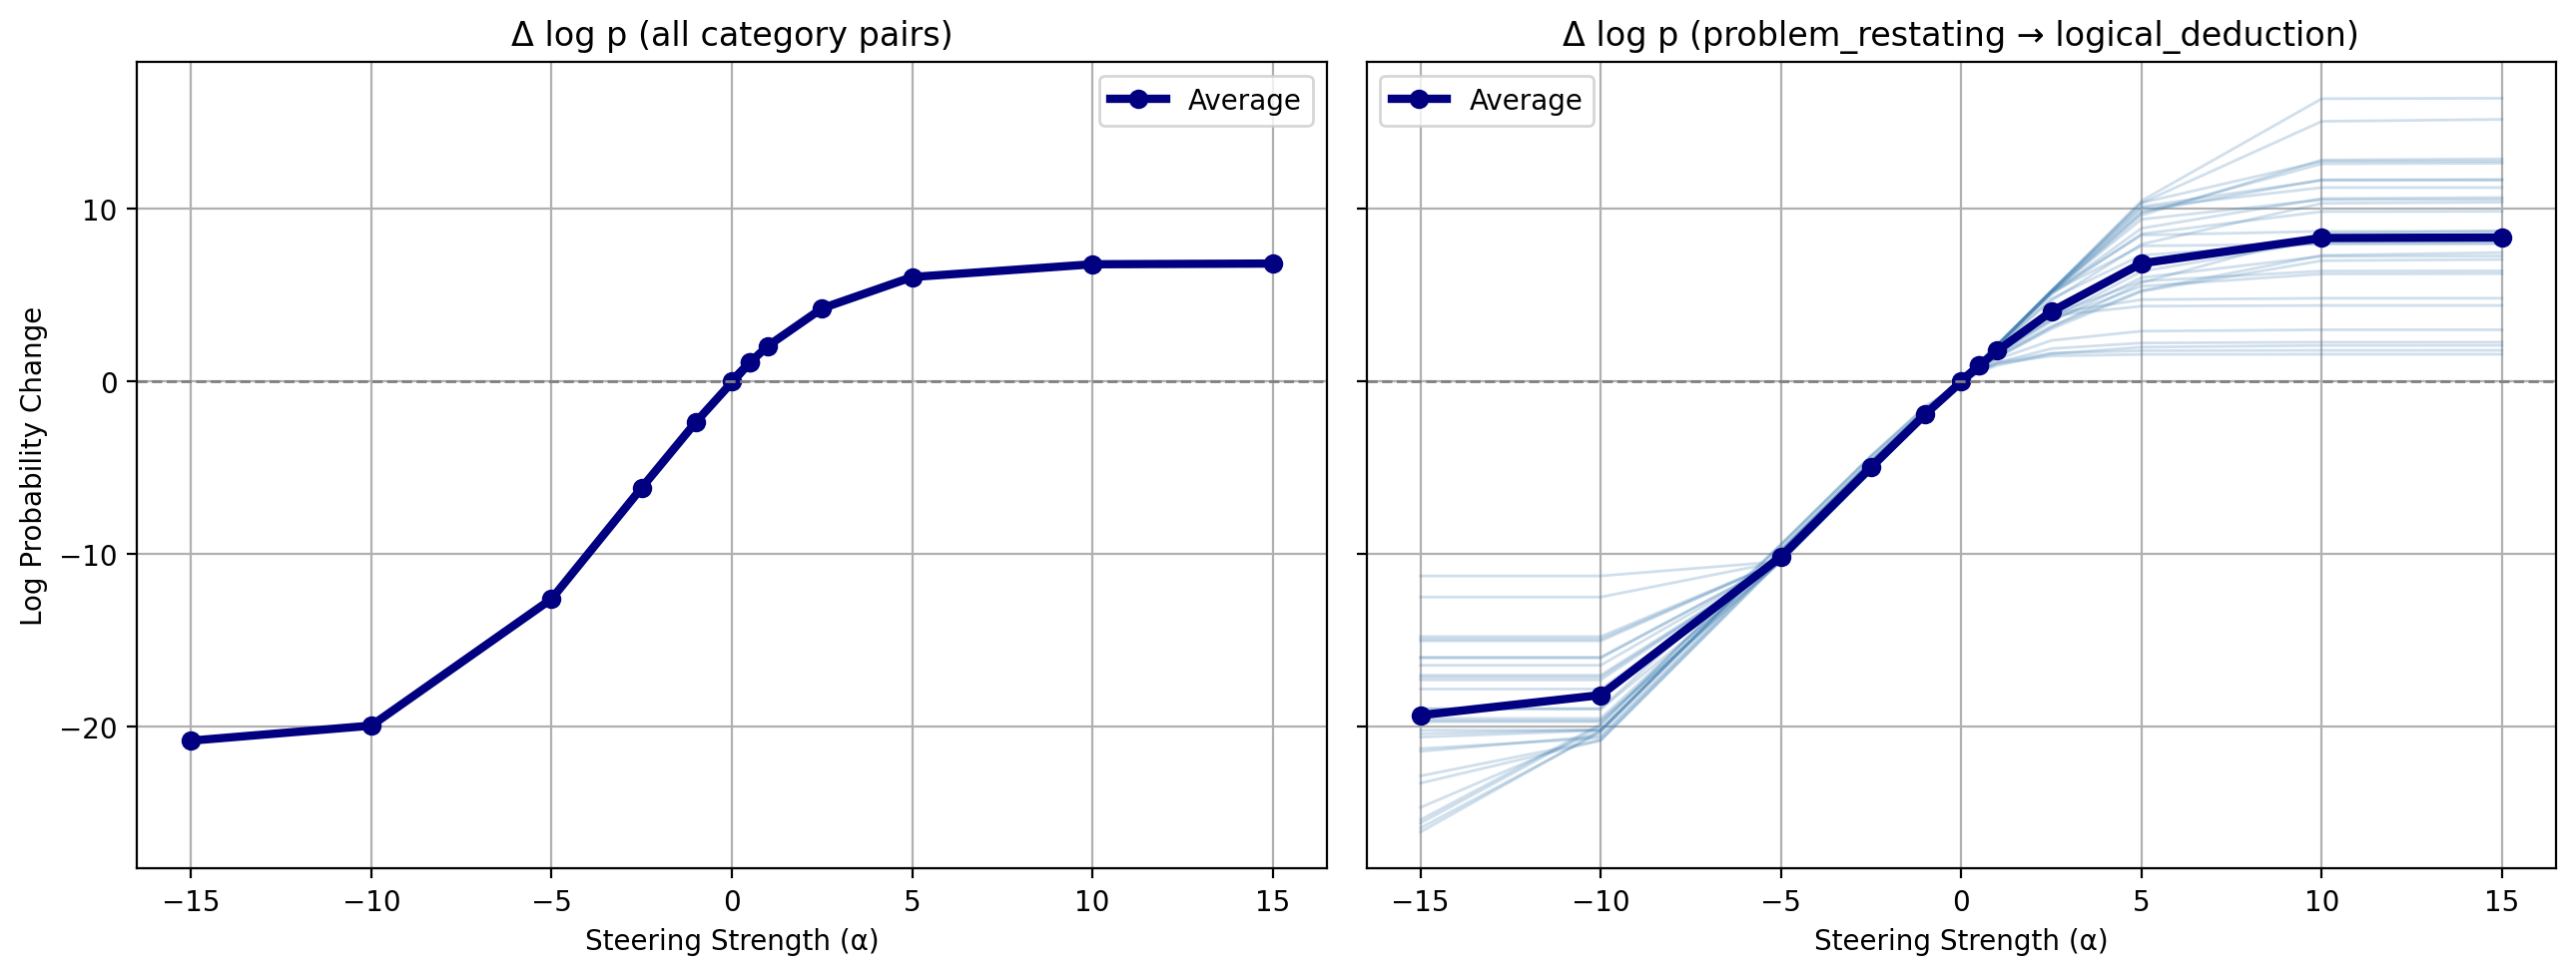

In [20]:
# ═══════════════════════════════════════════════════════════════
# Log-probability change vs. steering strength (α)
# ---------------------------------------------------------------
SRC_CAT  = "problem_restating"                    # steer FROM
TGT_CAT  = "logical_deduction"                    # steer TO
ALPHAS   = [-15, -10, -5, -2.5, -1, 0.5, 0, 0.5, 1, 2.5, 5, 10, 15]   # strengths (± OK)
# ═══════════════════════════════════════════════════════════════

import numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.special import softmax          # just in case

# ─── build centroids from the *train* split ─────────────────────
centroids = {k: np.stack(
        syco_train.loc[syco_train[CATEGORY_NAMES]
                       .values.argmax(1) == k, "vec"]
    ).mean(0) for k in range(len(CATEGORY_NAMES))}

src_idx, tgt_idx   = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction          = centroids[tgt_idx] - centroids[src_idx]
direction         /= np.linalg.norm(direction)

# sentences whose current probe label == SRC_CAT
mask_src = y_pred == src_idx
X_src    = X_test[mask_src]

# helper: log-probability of *target* category for a batch of vecs
def log_p_target(vec_batch):
    p = clf.predict_proba(vec_batch)          # (B, n_cat)
    # clip to keep log finite
    return np.log(np.clip(p[:, tgt_idx], 1e-12, 1.0))

# ─── compute Δ log p for every α and every sentence ─────────────
delta_logp = []          # list of (len(ALPHAS),) arrays  – one per sentence
for v in X_src:
    base = log_p_target(v[None, :])[0]           # α = 0 reference
    delta_logp.append([
        log_p_target((v + a * direction)[None, :])[0] - base
        for a in ALPHAS
    ])
delta_logp = np.stack(delta_logp)                # (n_sent, len(ALPHAS))

# ─── same thing but averaged across *all* ordered pairs ─────────
def sweep_all_pairs(alphas):
    """return (len(alphas),) array of mean Δlog p across all pairs/sentences"""
    out = np.zeros(len(alphas))
    count = 0
    for i in range(len(CATEGORY_NAMES)):
        vecs_i = X_test[y_pred == i]
        if len(vecs_i) == 0: continue
        for j in range(len(CATEGORY_NAMES)):
            if i == j: continue
            dir_ij = centroids[j] - centroids[i]
            dir_ij /= np.linalg.norm(dir_ij)
            base   = np.log(
                    np.clip(clf.predict_proba(vecs_i)[:, j], 1e-12, 1.0))
            for k,a in enumerate(alphas):
                steered = vecs_i + a * dir_ij
                p_j     = np.log(
                    np.clip(clf.predict_proba(steered)[:, j], 1e-12, 1.0))
                out[k] += (p_j - base).sum()
            count += len(vecs_i)
    return out / count if count else out

all_pairs_dlp = sweep_all_pairs(ALPHAS)

# ─── plotting ───────────────────────────────────────────────────
fig, axs = plt.subplots(1, 2, figsize=(13,5), sharey=True)

# ––– left: across *all* category pairs ––––––––––––––––––––––––
axs[0].plot(ALPHAS, all_pairs_dlp, marker='o',
            linewidth=3, color='navy', label="Average")
axs[0].axhline(0, ls='--', c='gray', lw=1)
axs[0].set_title("Δ log p (all category pairs)")
axs[0].set_xlabel("Steering Strength (α)")
axs[0].set_ylabel("Log Probability Change")
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(5))
axs[0].grid(True); axs[0].legend()

# ––– right: chosen SRC → TGT pair ––––––––––––––––––––––––––––
# faint per-sentence lines
for row in delta_logp:
    axs[1].plot(ALPHAS, row, c='steelblue', alpha=0.25, lw=1)
# bold average
axs[1].plot(ALPHAS, delta_logp.mean(0), marker='o',
            linewidth=3, color='navy', label="Average")
axs[1].axhline(0, ls='--', c='gray', lw=1)
axs[1].set_title(f"Δ log p ({SRC_CAT} → {TGT_CAT})")
axs[1].set_xlabel("Steering Strength (α)")
axs[1].grid(True); axs[1].legend()

plt.tight_layout()
plt.show()


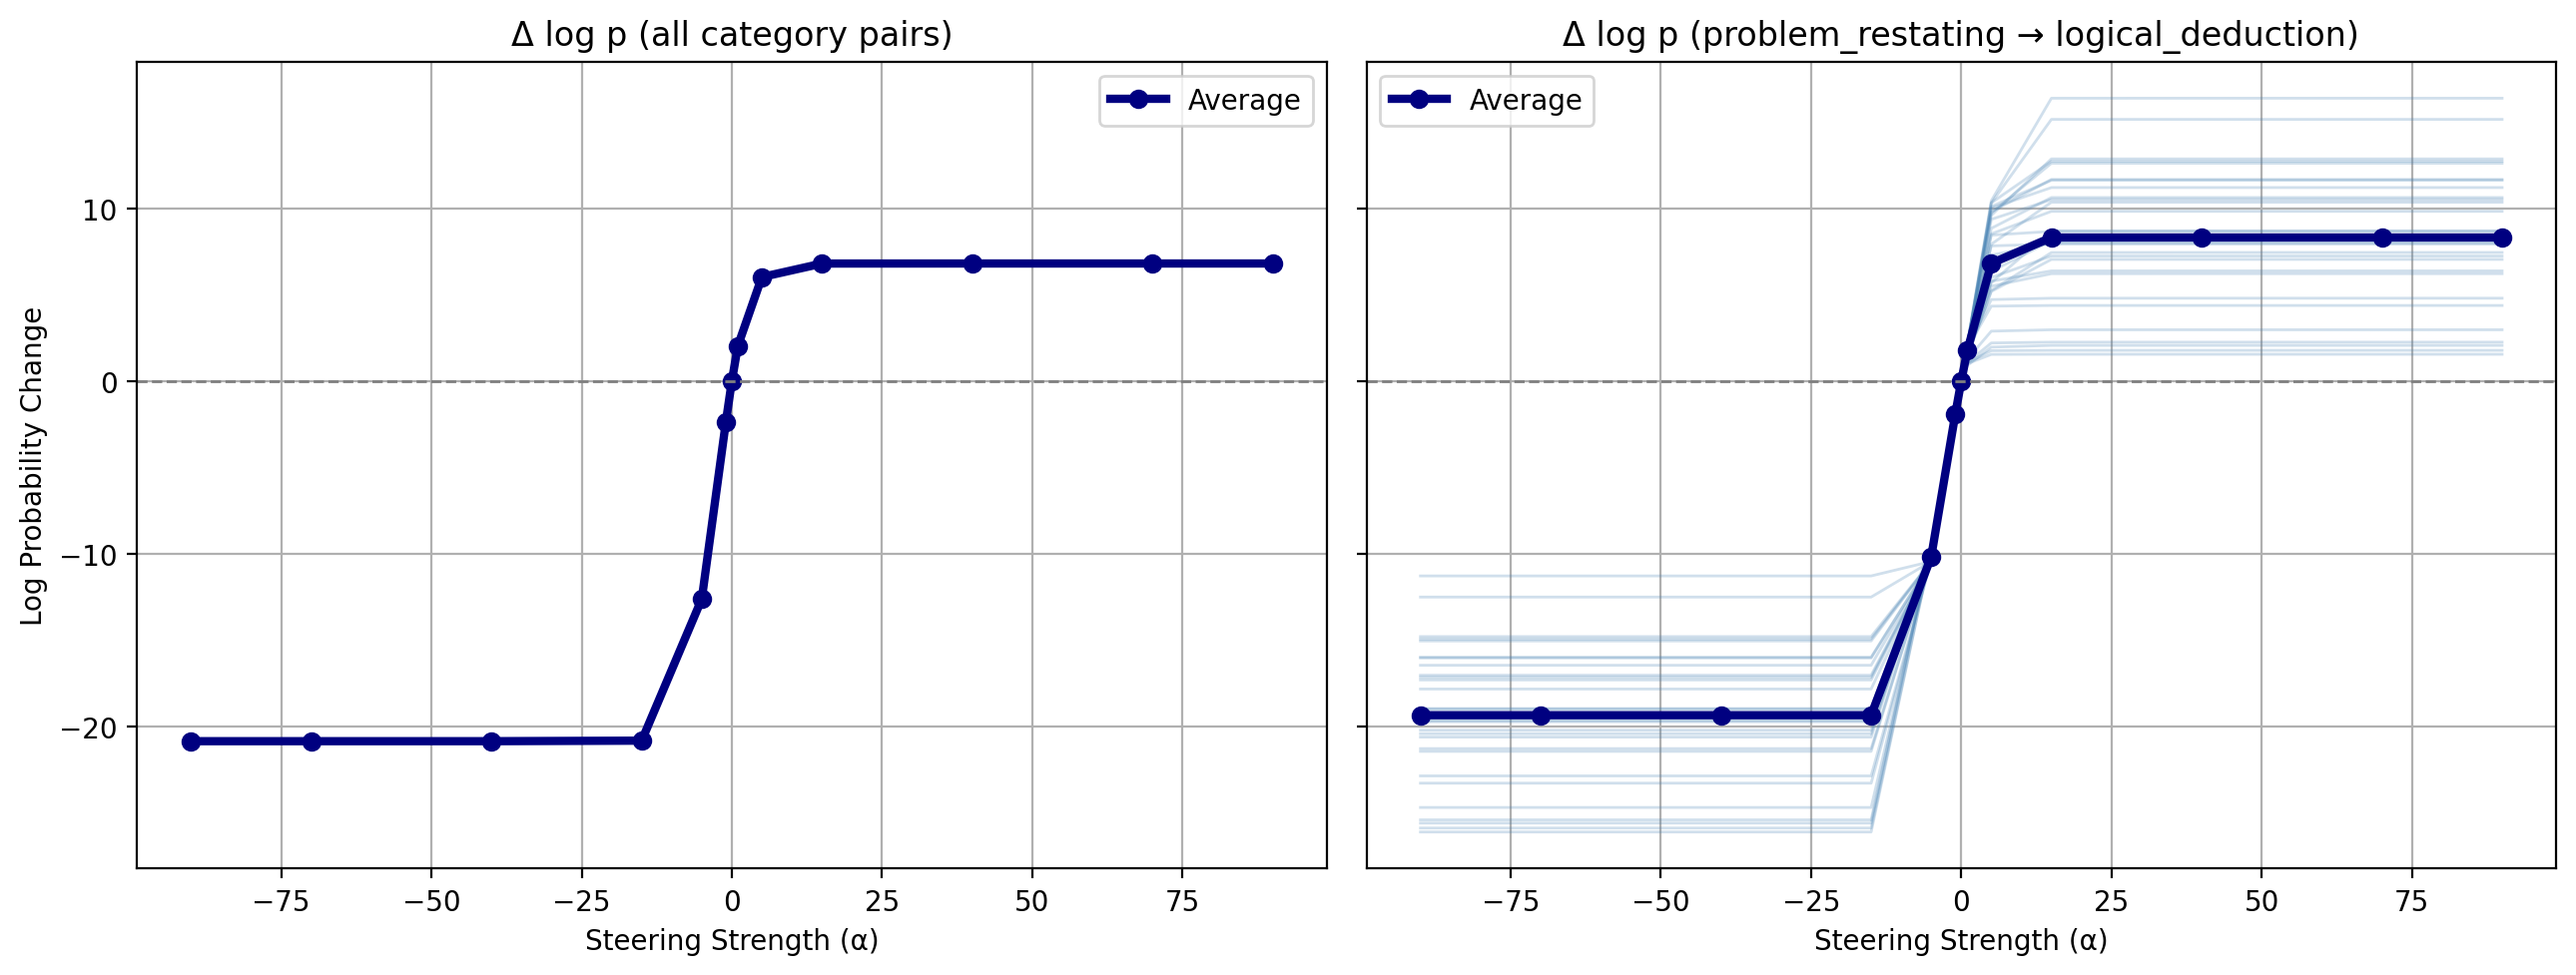

In [17]:
# ═══════════════════════════════════════════════════════════════
# Log-probability change vs. steering strength (α)
# ---------------------------------------------------------------
SRC_CAT  = "problem_restating"                    # steer FROM
TGT_CAT  = "logical_deduction"                    # steer TO
ALPHAS   = [-90, -70, -40, -15, -5, -1, 0, 1, 5, 15, 40, 70, 90]   # strengths (± OK)
# ═══════════════════════════════════════════════════════════════

import numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.special import softmax          # just in case

# ─── build centroids from the *train* split ─────────────────────
centroids = {k: np.stack(
        syco_train.loc[syco_train[CATEGORY_NAMES]
                       .values.argmax(1) == k, "vec"]
    ).mean(0) for k in range(len(CATEGORY_NAMES))}

src_idx, tgt_idx   = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction          = centroids[tgt_idx] - centroids[src_idx]
direction         /= np.linalg.norm(direction)

# sentences whose current probe label == SRC_CAT
mask_src = y_pred == src_idx
X_src    = X_test[mask_src]

# helper: log-probability of *target* category for a batch of vecs
def log_p_target(vec_batch):
    p = clf.predict_proba(vec_batch)          # (B, n_cat)
    # clip to keep log finite
    return np.log(np.clip(p[:, tgt_idx], 1e-12, 1.0))

# ─── compute Δ log p for every α and every sentence ─────────────
delta_logp = []          # list of (len(ALPHAS),) arrays  – one per sentence
for v in X_src:
    base = log_p_target(v[None, :])[0]           # α = 0 reference
    delta_logp.append([
        log_p_target((v + a * direction)[None, :])[0] - base
        for a in ALPHAS
    ])
delta_logp = np.stack(delta_logp)                # (n_sent, len(ALPHAS))

# ─── same thing but averaged across *all* ordered pairs ─────────
def sweep_all_pairs(alphas):
    """return (len(alphas),) array of mean Δlog p across all pairs/sentences"""
    out = np.zeros(len(alphas))
    count = 0
    for i in range(len(CATEGORY_NAMES)):
        vecs_i = X_test[y_pred == i]
        if len(vecs_i) == 0: continue
        for j in range(len(CATEGORY_NAMES)):
            if i == j: continue
            dir_ij = centroids[j] - centroids[i]
            dir_ij /= np.linalg.norm(dir_ij)
            base   = np.log(
                    np.clip(clf.predict_proba(vecs_i)[:, j], 1e-12, 1.0))
            for k,a in enumerate(alphas):
                steered = vecs_i + a * dir_ij
                p_j     = np.log(
                    np.clip(clf.predict_proba(steered)[:, j], 1e-12, 1.0))
                out[k] += (p_j - base).sum()
            count += len(vecs_i)
    return out / count if count else out

all_pairs_dlp = sweep_all_pairs(ALPHAS)

# ─── plotting ───────────────────────────────────────────────────
fig, axs = plt.subplots(1, 2, figsize=(13,5), sharey=True)

# ––– left: across *all* category pairs ––––––––––––––––––––––––
axs[0].plot(ALPHAS, all_pairs_dlp, marker='o',
            linewidth=3, color='navy', label="Average")
axs[0].axhline(0, ls='--', c='gray', lw=1)
axs[0].set_title("Δ log p (all category pairs)")
axs[0].set_xlabel("Steering Strength (α)")
axs[0].set_ylabel("Log Probability Change")
axs[0].yaxis.set_major_locator(ticker.MaxNLocator(5))
axs[0].grid(True); axs[0].legend()

# ––– right: chosen SRC → TGT pair ––––––––––––––––––––––––––––
# faint per-sentence lines
for row in delta_logp:
    axs[1].plot(ALPHAS, row, c='steelblue', alpha=0.25, lw=1)
# bold average
axs[1].plot(ALPHAS, delta_logp.mean(0), marker='o',
            linewidth=3, color='navy', label="Average")
axs[1].axhline(0, ls='--', c='gray', lw=1)
axs[1].set_title(f"Δ log p ({SRC_CAT} → {TGT_CAT})")
axs[1].set_xlabel("Steering Strength (α)")
axs[1].grid(True); axs[1].legend()

plt.tight_layout()
plt.show()


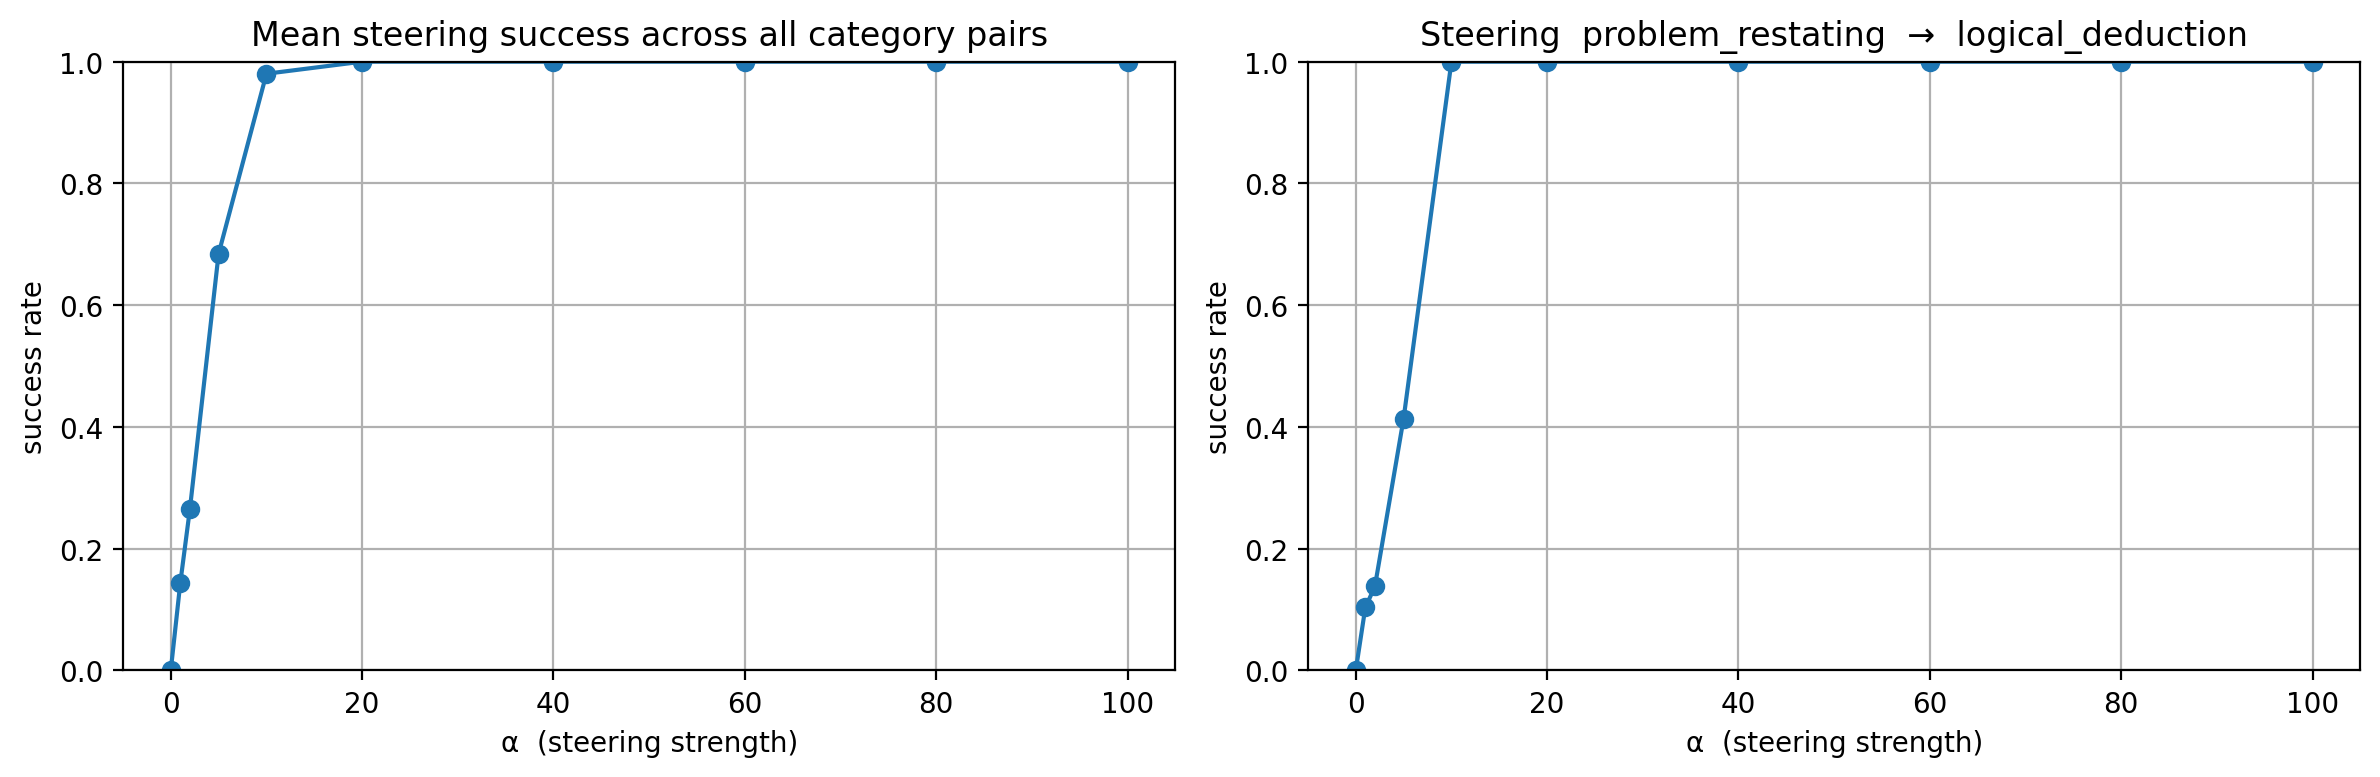

Overall α-vs-success correlation :  0.659
problem_restating→logical_deduction correlation   :  0.691


In [15]:
# ══════════════════════════════════════════════════════════════════
# Steering-strength vs. success – tunable category pair
# ------------------------------------------------------------------
SRC_CAT  = "problem_restating"                    # ← steer FROM
TGT_CAT  = "logical_deduction"                    # ← steer TO
ALPHAS   = [0, 1, 2, 5, 10, 20, 40, 60, 80, 100]  # steering magnitudes
# ══════════════════════════════════════════════════════════════════

import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

# (re-)build centroids from the train split ------------------------
centroids = {k: np.stack(
    syco_train.loc[syco_train[CATEGORY_NAMES].values.argmax(1)==k, "vec"]
).mean(0) for k in range(len(CATEGORY_NAMES))}

# ------------------------------------------------------------------
src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
mask_src         = y_pred == src_idx
X_src_test       = X_test[mask_src]

def success_pair(alpha: float) -> float:
    """Success rate steering SRC→TGT with a given α."""
    direction = centroids[tgt_idx] - centroids[src_idx]
    direction /= np.linalg.norm(direction)
    steered    = X_src_test + alpha * direction
    return (clf.predict(steered) == tgt_idx).mean()

def success_all(alpha: float) -> float:
    """Mean success rate across **all** ordered category pairs."""
    total, n = 0.0, 0
    for i in range(len(CATEGORY_NAMES)):
        vecs_i = X_test[y_pred == i]
        if len(vecs_i) == 0:          # nothing predicted as i
            continue
        for j in range(len(CATEGORY_NAMES)):
            if i == j:                # skip self-steering
                continue
            dir_ij = centroids[j] - centroids[i]
            dir_ij /= np.linalg.norm(dir_ij)
            steered = vecs_i + alpha * dir_ij
            total  += (clf.predict(steered) == j).mean()
            n      += 1
    return total / n if n else 0.0

pair_scores = [success_pair(a) for a in ALPHAS]
all_scores  = [success_all(a)  for a in ALPHAS]

# ─── plots ─────────────────────────────────────────────────────────
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(ALPHAS, all_scores, marker="o")
plt.title("Mean steering success across all category pairs")
plt.xlabel("α  (steering strength)")
plt.ylabel("success rate")
plt.ylim(0,1); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ALPHAS, pair_scores, marker="o")
plt.title(f"Steering  {SRC_CAT}  →  {TGT_CAT}")
plt.xlabel("α  (steering strength)")
plt.ylabel("success rate")
plt.ylim(0,1); plt.grid(True)

plt.tight_layout()
plt.show()

# ─── Pearson correlations ─────────────────────────────────────────
corr_all  = pearsonr(ALPHAS, all_scores)[0]
corr_pair = pearsonr(ALPHAS, pair_scores)[0]
print(f"Overall α-vs-success correlation : {corr_all:6.3f}")
print(f"{SRC_CAT}→{TGT_CAT} correlation   : {corr_pair:6.3f}")


In [69]:
# ═════════════ Live steering with saved vectors ═════════════
import re, json, numpy as np, torch, math
from pathlib import Path

# ─── user settings ─────────────────────────────────────────────────
MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "forward_planning" # steer TO
ALPHA          = 90.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        # ── decide if we steer the *next* token  ──────────────────
        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        # ── print & feed next token ───────────────────────────────
        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)   # grow input for next step

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:10:26,709 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:10:27,204 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


<<STEER START>> <｜end▁of▁sentence｜>

 think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think think<<STEER END>>



In [70]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "forward_planning" # steer TO
ALPHA          = 10.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:11:19,292 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:11:19,820 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
2025-05-04 03:11:20,312 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

Alright, so I'm trying to figure out which compromise of the New Economic Policy that Lenin is talking about in his speech. First, I need to understand the context of the speech. It's from 1928, and Lenin is talking about the industrialization of the country and the right deviation in the Communist Party. He mentions that the independence of the country can't be maintained without a strong industrial base, and that the industry needs to be more technically advanced. He also says that the Soviet regime can't continue to rely on two

KeyboardInterrupt: 

In [71]:
# ═════════════ Live steering with saved vectors ═════════════
import re, json, numpy as np, torch, math
from pathlib import Path

# ─── user settings ─────────────────────────────────────────────────
MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "forward_planning" # steer TO
ALPHA          = 0.5                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        # ── decide if we steer the *next* token  ──────────────────
        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        # ── print & feed next token ───────────────────────────────
        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)   # grow input for next step

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:14:01,395 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:14:01,872 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://



The question asks which compromise of the New Economic Policy needs to be fixed according to Lenin's speech. The New Economic Policy (NEP) was a set of economic policies implemented by the Soviet government after the Russian Revolution, aiming to transition from a war economy to a peaceful one by introducing limited capitalist elements. Lenin's speech emphasizes the need for industrialization and the importance of developing socialist industry to ensure the country's independence and the stability of the socialist regime. He mentions that relying on the small-scale, backward commodity economy of the peasants is unsustainable and that the country must move towards large-scale, modernized production. Therefore, the compromise that needs to be fixed is the continuation of the NEP's policies that hindered the development of large-scale socialist industry. The correct answer is:

<<STEER END>>



In [72]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 10.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:25:57,798 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:25:58,869 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]
2025-05-04 03:25:59,373 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The correct answer is: B. The New Economic Policy should be modified to ensure that the development of industry is prioritized over agriculture.

The reasoning is that Lenin emphasizes the need for industrialization to support the Soviet regime and socialist construction, stating that the independence of the country cannot be maintained without a strong industrial base. He mentions that the current economic policy is based on two foundations: a large-scale socialist industry and a scattered, backward small commodity economy of the

KeyboardInterrupt: 

In [77]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "answer_reporting" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:30:42,157 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:30:42,614 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

answer
</think><<STEER END>>



In [79]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "answer_reporting" # steer TO
ALPHA          = 22.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:32:22,119 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:32:22,593 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>

://answer
Alright, I'm trying to answer this question about Lenin's speech and the New Economic Policy. Let me read through the speech again to understand the context.

Lenin is talking about the importance of industrialization for the independence of the country. He mentions that the Soviet regime and socialist construction cannot be sustained if the industry isn't developed enough. He specifically refers to the New Economic Policy (NEP) and says that it's not working as it should. He emphasizes the need to move away from the current economic system, which is based on a combination of large-scale socialist industry and a backward, small-scale peasant economy. He's concerned that if they don't transition to a more advanced system, they might have to return to capitalism.

So, the question is asking which compromise<<STEER END>>



In [86]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "decision_confirmation" # steer TO
ALPHA          = 40.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:35:24,008 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:35:24,617 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]
2025-05-04 03:35:25,156 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://answer
Option A: Yes, B: Yes, C: Yes, D: Yes, E: Yes, F: Yes, G: Yes, H: Yes, I: Yes, J: Yes, K: Yes, L: Yes, M: Yes, N: Yes, O: Yes, P: Yes, Q: Yes, R: Yes, S: Yes, T: Yes, U: Yes, V: Yes, W: Yes, X: Yes, Y: Yes, Z: Yes, A: Yes, B: Yes, C: Yes, D: Yes, E: Yes, F: Yes, G: Yes, H: Yes, I: Yes, J: Yes, K: Yes, L: Yes, M:<<STEER END>>



In [87]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "decision_confirmation" # steer TO
ALPHA          = 35.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()


2025-05-04 03:42:57,776 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:42:58,377 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

answer
Option A: Yes, the answer is A.
</think><<STEER END>>



In [89]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "problem_restating" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:44:42,560 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 03:44:43,031 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


<<STEER START>>  The options are

:

A. The NEP allowed for limited private enterprise.

B. The NEP allowed for the expansion of state-controlled industry.

C. The NEP allowed for the continuation of the old agrarian system.

D. The NEP allowed for the development of a large-scale agricultural system.

E. The NEP allowed for the continuation of the old economic policies of the tsarist regime.

Hmm, okay. So first, I need to recall what the New Economic Policy (NEP) was. From what I remember, after the Russian Revolution, the Bolsheviks implemented the NEP as an economic policy to transition from a war economy to a peaceful socialist economy. It was introduced in 1921 and lasted until 1928 when it was replaced by the Five-Year Plan.

<<STEER END>>



In [90]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "problem_restating" # steer TO
ALPHA          = 20.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:45:55,347 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 03:45:55,798 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]
2025-05-04 03:45:56,313 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>>  The options are:

A. The NEP allowed for limited private enterprise.

B. The NEP allowed for the expansion of state-controlled industry.

C. The NEP allowed for the continuation of the old agrarian system.

D. The NEP allowed for the development of a large-scale agricultural system.

E. The NEP allowed for the continuation of the old economic policies of the tsarist regime.

Hmm, okay. So first, I need to recall what the New Economic Policy (NEP) was. From what I remember, after the Russian Revolution, the Bolsheviks implemented the NEP as an economic policy to transition from a war economy to a peaceful socialist economy. It

KeyboardInterrupt: 

In [91]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "logical_deduction" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:49:04,159 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 03:49:04,638 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


<<STEER START>>  The options

 are not provided, but the question is about the NEP, so I should probably think about the NEP and the context of the speech.

First, I should recall what the New Economic Policy (NEP) was. From what I remember, after the Russian Revolution, Lenin and the Bolsheviks implemented the NEP in 1921. The NEP was an economic policy that allowed some aspects of the old capitalist economy to function, especially in agriculture, to recover from the war and rebuild the economy. It involved allowing limited private enterprise, especially in areas like agriculture, to stimulate production. This was a temporary measure, as the goal was to eventually move towards a socialist economy.

In the given speech, Lenin is talking about the importance of industrialization. He says that the independence of<<STEER END>>



In [93]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "logical_deduction" # steer TO
ALPHA          = 20.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:54:18,431 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:54:18,884 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://



But perhaps the correct answer is not listed, or perhaps I made a mistake. Let me think again.

The question is asking which compromise of the New Economic Policy needs to be fixed according to Lenin's speech. From the speech, Lenin emphasizes the importance of industrialization and the need to move away from a small-scale, scattered economy towards large-scale, modernized socialist industry. This suggests that the New Economic Policy (NEP) was a temporary measure, and Lenin is pointing out that it cannot be a long-term solution. Therefore, the compromise that needs to be fixed is the continuation of the NEP, as it is not sustainable for the socialist construction.

So, the correct answer is likely that the NEP should be abandoned or modified to focus more on industrialization.

But<<STEER END>>



In [100]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "option_elimination" # steer TO
ALPHA          = 20.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:57:39,718 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:57:40,413 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]
2025-05-04 03:57:41,350 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The correct answer is B. Lenin is referring to the New Economic Policy (NEP) in his speech. He mentions that the Soviet regime cannot be sustained indefinitely if it is based on two different economic foundations: the advanced socialist industry and

KeyboardInterrupt: 

In [102]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "option_elimination" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 03:59:33,405 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 03:59:33,895 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
2025-05-04 03:59:34,430 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

Option A: NEP doesn't necessarily imply that the peas peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not necessarily imply that the peas not

KeyboardInterrupt: 

In [104]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 40.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:01:23,853 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:01:25,677 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]
2025-05-04 04:01:26,215 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>:// I think maybe I'm not sure. Let me think again.

The question is asking which compromise of the New Economic Policy needs to be fixed according to Lenin's speech. From the speech, Lenin talks about the need for industrialization and the importance of developing socialist industry. He mentions that the Soviet regime cannot be sustained if industry is not developed enough. He also refers to the

KeyboardInterrupt: 

In [105]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:03:13,574 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:03:14,051 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://



I think the correct answer is B. Lenin is saying that the New Economic Policy needs to be fixed by gradually moving towards large-scale production in agriculture and eliminating the small commodity economy of the peasants. This aligns with the idea of building a more advanced industrial base as he mentions in the speech.

**Step-by-step explanation:**

1. **Understanding the Context**: The speech by Lenin discusses the importance of industrialization for the Soviet regime and socialist construction.
2. **Key Points**: Lenin emphasizes the need for a fast rate of industrial development and the necessity to move away from a scattered, small-scale peasant economy.
3. **NEP and Its Issues**: The New Economic Policy (NEP) allowed for some capitalist elements, which Lenin refers to as the "small commodity economy<<STEER END>>



In [106]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 20.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:04:06,464 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:04:07,055 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s]
2025-05-04 04:04:07,451 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

I think the correct answer is B. Lenin is saying that the

KeyboardInterrupt: 

In [107]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 10.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:04:38,523 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:04:39,016 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://



The correct answer is: B. The New Economic Policy should be modified to ensure that the development of industry is prioritized over agriculture.

The reasoning is that Lenin emphasizes the need for industrialization to support the Soviet regime and socialist construction, stating that the independence of the country cannot be maintained without a strong industrial base. He mentions that the current economic policy is based on two foundations: a large-scale socialist industry and a scattered, backward small commodity economy of the peasants. Lenin advocates for a gradual transition to placing agriculture on a new technical basis, similar to socialist industry, to ensure the final victory of socialism. Therefore, the New Economic Policy needs to be modified to prioritize industrial development over agriculture to achieve this goal.

The correct option is B.
</think><<STEER END>>



In [108]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 0.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:04:56,140 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:04:56,626 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]
2025-05-04 04:04:57,113 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>://

The question asks which compromise of the New Economic Policy needs to be fixed according to Lenin's speech. The New Economic Policy (NEP) was a set of economic policies implemented by the Soviet government after the Russian Revolution, aiming to transition from a war economy to a peaceful one by introducing limited capitalist elements. Lenin's speech emphasizes the need for industrialization and the importance of developing socialist industry to ensure the country's independence and the stability of the socialist regime. He mentions that relying on the small-scale, backward commodity economy of the peasants is unsustainable and that the country must move towards large-scale, modernized production. Therefore, the compromise that needs to be fixed is the continuation of the NEP's policies that hindered

KeyboardInterrupt: 

In [109]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 50.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:08:23,903 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:08:24,396 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>

:// maybe I'm not sure if I'm remembering it correctly. Let me think.

The question is about which compromise of the New Economic Policy (NEP) Lenin is referring to in his speech. The New Economic Policy was implemented by the Bolshevik government after the Russian Revolution to stabilize the economy during a time of war and economic disruption. It allowed for some capitalist practices, such as limited private enterprise and a market for certain goods, while moving towards a socialist economy.

In the speech, Lenin emphasizes the need for industrialization and the importance of developing heavy industry to support the socialist state. He talks about the need to move away from relying on the small-scale, scattered economy of the peasants and to build a more advanced industrial base. He mentions that if this task is not accomplished, the victory<<STEER END>>



In [110]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 60.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:08:41,691 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:08:42,182 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]
2025-05-04 04:08:42,709 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>:// maybe sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes

KeyboardInterrupt: 

In [111]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "problem_restating"                   # steer FROM
TGT_CAT        = "uncertainty_or_certainty_expression" # steer TO
ALPHA          = 70.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:09:39,160 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 Okay, so I have this question about a speech by Vladimir Lenin, and I need to figure out which of the given options is a compromise he's talking about in his New Economic Policy. 



2025-05-04 04:09:39,652 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


<<STEER START>> <｜end▁of▁sentence｜><｜begin▁of▁sentence｜>

:// maybe sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes sometimes 

In [112]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "problem_restating" # steer TO
ALPHA          = 70.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:13:06,047 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 04:13:06,738 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
2025-05-04 04:13:08,840 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>>  The options are:

 A. The NEP allowed for limited private enterprise.

 B. The NEP allowed for the expansion of state-controlled industry.

 C. The NEP allowed for the continuation

KeyboardInterrupt: 

In [113]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "problem_restating" # steer TO
ALPHA          = 60.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:14:14,372 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 04:14:14,898 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


<<STEER START>>  The options are

:

A. The NEP allowed for limited private enterprise.

B. The NEP allowed for the expansion of state-controlled industry.

C. The NEP allowed for the continuation of the old agrarian system.

D. The NEP allowed for the development of a large-scale agricultural system.

E. The NEP allowed for the continuation of the old economic policies of the tsarist regime.

Hmm, okay. So first, I need to recall what the New Economic Policy (NEP) was. From what I remember, after the Russian Revolution, the Bolsheviks implemented the NEP as an economic policy to transition from a war economy to a peaceful socialist economy. It was introduced in 1921 and lasted until 1928 when it was replaced by the Five-Year Plan.

<<STEER END>>



In [119]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "decision_confirmation" # steer TO
ALPHA          = 30.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:16:03,529 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 04:16:03,980 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


<<STEER START>>  The options are

 A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z. But since the user didn't list them, I'll have to infer based on the context.

First, I need to understand the context of the speech. The speech is titled "Industrialization of the Country and the Right Deviation in the C.P.S.U., November 19,1928." From what I remember, Lenin was a key figure in the Russian Revolution and the establishment of the Soviet Union. The New Economic Policy (NEP) was a set of economic measures taken by the Bolsheviks after the revolution,<<STEER END>>



In [122]:
import re, json, numpy as np, torch, math
from pathlib import Path

MODEL          = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
VEC_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "cat_probe/none_unverb_2001.json")        # ← probe vectors JSON
CAT_FILE       = Path(
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/"
    "confidence/none_unverb_2001.json")       # ← category labels JSON
QUESTIONS_FILE = Path("data/mmlu/input_mcq_data.json")
COT_FILE       = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/"
                      "completions_with_2001.json")

QID            = 68                                    # which question
SRC_CAT        = "knowledge_augmentation"                   # steer FROM
TGT_CAT        = "decision_confirmation" # steer TO
ALPHA          = 10.0                                  # push strength
FIRST_TOKEN    = False                                  # False ⇒ every token
# ────────────────────────────────────────────────────────────────

CATEGORY_NAMES = [
 "problem_restating","knowledge_augmentation","assumption_validation",
 "logical_deduction","option_elimination","uncertainty_or_certainty_expression",
 "backtracking","forward_planning","decision_confirmation",
 "answer_reporting","option_restating","other",
]

# 1 ── build centroids from stored sentence vectors ───────────────
vec_rows = []
for obj in json.loads(VEC_FILE.read_text()):
    for s in obj["sentences"]:
        vec_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": s["sentence_id"],
            "vec": np.array(s["sent_vec"], dtype=np.float32)
        })
vec_df = { (r["question_id"], r["sentence_id"]) : r["vec"]  for r in vec_rows }

lab_rows = []
for obj in json.loads(CAT_FILE.read_text()):
    for ann in obj["annotations"]:
        lab_rows.append({
            "question_id": obj["question_id"],
            "sentence_id": ann["sentence_id"],
            **{c: ann[c] for c in CATEGORY_NAMES}
        })
lab_df = { (r["question_id"], r["sentence_id"]) : r  for r in lab_rows }

centroids = {}
for k, cat in enumerate(CATEGORY_NAMES):
    vecs = [vec_df[key] for key in vec_df
            if key in lab_df and lab_df[key][cat] >= 0.5]
    if vecs: centroids[k] = np.stack(vecs).mean(0)

src_idx, tgt_idx = CATEGORY_NAMES.index(SRC_CAT), CATEGORY_NAMES.index(TGT_CAT)
direction = centroids[tgt_idx] - centroids[src_idx]
direction /= np.linalg.norm(direction)
direction = torch.tensor(direction)

# 2 ── find target sentence in stored CoT ──────────────────────────
# 2 ── load CoT & determine target sentence ──────────────────────
cot_obj = next(x for x in json.loads(COT_FILE.read_text()) if x["question_id"]==QID)
cot_text= cot_obj["completion"]
body    = cot_text[cot_text.find("<think>")+7 : cot_text.find("</think>")]
sents   = re.split(r"(?<=\.)\s+", re.sub(r"\s+", " ", body.strip()))

# pick first sentence whose label ≥0.5 for SRC_CAT
target_sid = next(
    #sid for (qid, sid), ann in lab_map.items()
    #if qid == QID and ann[SRC_CAT] >= 0.5
    sid for (qid, sid), ann in lab_df.items()
    if qid == QID and ann[SRC_CAT] >= 0.5
)

prefix = " ".join(sents[:target_sid-1])

print("TARGET sentence:\n", sents[target_sid-1], "\n")


# 3 ── build prompt (question + CoT-prefix) ────────────────────────
question = next(q["question"] for q in json.loads(QUESTIONS_FILE.read_text())
                if q["question_id"]==QID)
from a_confirm_posthoc.main.prompt_constructor import construct_prompt
prompt_txt = construct_prompt({"question": question, "hint_text": None})
prompt_txt = prompt_txt.replace(question, question + "\n\n<think>" + prefix)

# 4 ── load model & tokenizer ──────────────────────────────────────
from c_cluster_analysis.cat_probe_2.inf_capture_penult import load_model_and_tokenizer
model, tok, _, _ = load_model_and_tokenizer(MODEL); model.eval()
penult = model.model.layers[-2]
ids    = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)

# 4b ── prepare steering delta in (1, n_heads, head_dim) shape ────
hidden_size = model.config.hidden_size            # e.g. 4096
n_heads      = model.config.num_attention_heads    # e.g. 32
head_dim     = hidden_size // n_heads              # 128
delta = (ALPHA * direction.to(model.device)
         .view(1, n_heads, head_dim))              # (1,32,128)


# 6 ── generation with KV-cache patching ───────────────────────────
# 6 ── generation with in-flight hidden-state patch  ───────────────
print("\n<<STEER START>>", end=" ", flush=True)

# ── one-time steering vector in (hidden_size,) ────────────────────
delta_vec = (ALPHA * direction).to(model.device)

class SteerPenult:
    """
    Forward-hook on the penultimate transformer block; when `self.active`
    it adds the delta to the *last* token’s hidden state of the batch.
    """
    def __init__(self):
        self.active = False          # set from outside before each step
    def __call__(self, _mod, _inp, out):
        if self.active:
            h = out[0]               # (1, seq_len, D)
            h[:, -1, :] += delta_vec.to(h.dtype)
        return out

steer_hook = SteerPenult()
hndl = penult.register_forward_hook(steer_hook)

# ── streaming generation (greedy)  ────────────────────────────────
ids        = tok(prompt_txt, return_tensors="pt").input_ids.to(model.device)
cur_sent   = prefix.count(".")       # sentences already supplied
tok_in_sent= 0

with torch.no_grad():
    for step in range(160):
        out   = model(input_ids = ids)
        logits = out.logits
        next_id = torch.argmax(logits[:, -1], dim=-1, keepdim=True)  # greedy
        tok_txt = tok.decode(next_id[0])

        # ── update sentence / token counters ──────────────────────
        if tok_txt.strip("▁") in {".", "?", "!"}:
            cur_sent   += 1
            tok_in_sent = 0
        else:
            tok_in_sent += 1

        steer_hook.active = (
            (cur_sent + 1) == target_sid and
            (not FIRST_TOKEN or tok_in_sent == 0)
        )

        print(tok_txt, end="", flush=True)
        if tok_txt == "</think>":
            break
        ids = torch.cat([ids, next_id], dim=-1)

print("<<STEER END>>\n")
hndl.remove()

2025-05-04 04:17:28,647 - INFO - loading deepseek-ai/DeepSeek-R1-Distill-Llama-8B on cuda


TARGET sentence:
 First, I remember that the New Economic Policy (NEP) was a set of economic measures taken by the Bolshevik government after the Russian Civil War. 



2025-05-04 04:17:29,147 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
2025-05-04 04:17:29,854 - WARNING - Some parameters are on the meta device because they were offloaded to the cpu.



<<STEER START>>  The options are A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z. But since the user didn't list them, I'll have to infer based on the context.

First, I need to understand the context of

KeyboardInterrupt: 